<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/EEG_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [70]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
sns.set

<function seaborn.rcmod.set>

In [4]:
working_path = Path('/content/drive/MyDrive/CoganLab')

In [5]:
eeg = pd.read_csv(
    working_path.joinpath('eeg_all.csv'),
    index_col=None
)

## Preprocessing

In [6]:
eeg.columns

Index(['Unnamed: 0', 'Trial', 'Subject', 'Block', 'ProbeType', 'ProbeTypeName',
       'StimulusCategory', 'ListenCue', 'ReactionTime', 'KeyCode', 'Response',
       'ResponseCorrect', 'Omission', 'StimulusAudioStart',
       'StimulusAlignedTrigger', 'DelayPeriodOnset', 'MaintenancePeriodOnset',
       'ProbeCueOnset', 'ProbeAudioStart', 'ProbeAlignedTrigger',
       'TriggerValueCondition', 'StimulusSounds_idx', 'StimulusSounds_name',
       'ProbeCategory', 'ProbeSound_idx', 'ProbeSound_name'],
      dtype='object')

In [7]:
eeg = eeg.loc[:, eeg.columns != 'Unnamed: 0'] # some extra column appeared while uploading data

In [8]:
eeg.isnull().sum()

Trial                       0
Subject                     0
Block                       0
ProbeType                   0
ProbeTypeName               0
StimulusCategory            0
ListenCue                   0
ReactionTime              100
KeyCode                     0
Response                    0
ResponseCorrect             0
Omission                    0
StimulusAudioStart          0
StimulusAlignedTrigger      0
DelayPeriodOnset            0
MaintenancePeriodOnset      0
ProbeCueOnset               0
ProbeAudioStart             0
ProbeAlignedTrigger         0
TriggerValueCondition       0
StimulusSounds_idx          0
StimulusSounds_name         0
ProbeCategory               0
ProbeSound_idx              0
ProbeSound_name             0
dtype: int64

In [9]:
len(eeg.Subject.unique())

29

In [10]:
eeg.shape

(5568, 25)

In [11]:
eeg_subset = eeg[[
                 'Trial', 'Subject', 'Block', 'ProbeType', 'ProbeSound_idx',
                 'ProbeTypeName', 'StimulusCategory', 'ReactionTime', 'KeyCode',
                 'Response', 'ResponseCorrect', 'Omission', 'ProbeCategory',
                  'StimulusSounds_name', 'ProbeSound_name', 'StimulusSounds_idx'                 
]]

In [12]:
eeg_subset.head()

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,ResponseCorrect,Omission,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx
0,0,E2,1,1,21,out_of_sequence,High Words,NaN,2.Left3.Left,No Response,0,No Response,Low Words,"[array(['mon.wav'], dtype='<U7'), array(['pcn....",Sur.wav,"[6, 7, 8, 4, 10]"
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,1,Responded,Low Non-words,"[array(['yuf.wav'], dtype='<U7'), array(['JcG....",ycG.wav,"[39, 32, 35, 37, 38]"
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,1,Responded,Low Words,"[[array(['tub.wav'], dtype='<U7')]\n [array(['...",yuT.wav,[[27 23 22 24 25 29 26 28 30]]
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,1,Responded,High Words,"[array(['fEl.wav'], dtype='<U7'), array(['lEr....",lEr.wav,"[2, 5, 8, 4, 6]"
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,1,Responded,High Non-Words,"[[array(['gWT.wav'], dtype='<U7')]\n [array(['...",g@n.wav,[[34 35 36 40 39 33 37]]


Checking for accuracy of subjects

In [13]:
# creating CorrPercentage variable
eeg_subset['CorrPercentage'] = np.nan
subjects = eeg_subset['Subject'].unique().tolist()
length = eeg_subset.groupby(['Subject'])['Trial'].count() # number of trials per subject
correct = eeg_subset.groupby(['Subject'])['ResponseCorrect'].sum() # sum of correct answers per subject
for subj in subjects:
  value = correct[subj] / length[subj]
  eeg_subset.loc[eeg_subset['Subject'] == subj, 'CorrPercentage'] = value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [14]:
# check if any of the subjects is less than 75 % accurate
(eeg_subset.groupby(['Subject'])['CorrPercentage'].first() < 0.75).any()

False

Cleaning 'No response' trials

In [15]:
# the list of subject with 'No response' trials
eeg_subset[eeg_subset['Response'] == 'No Response'].Subject.unique()

array(['E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E10', 'E11', 'E13', 'E15',
       'E17', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27',
       'E28', 'E29', 'E30', 'E31', 'E33'], dtype=object)

In [16]:
# deleting all the trials with no responses
eeg_clean = eeg_subset[eeg_subset['Response'] != 'No Response']

In [17]:
eeg_clean.isnull().sum()

Trial                  0
Subject                0
Block                  0
ProbeType              0
ProbeSound_idx         0
ProbeTypeName          0
StimulusCategory       0
ReactionTime           0
KeyCode                0
Response               0
ResponseCorrect        0
Omission               0
ProbeCategory          0
StimulusSounds_name    0
ProbeSound_name        0
StimulusSounds_idx     0
CorrPercentage         0
dtype: int64

Creating additional variables

In [18]:
eeg_clean.head()

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,ResponseCorrect,Omission,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx,CorrPercentage
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,1,Responded,Low Non-words,"[array(['yuf.wav'], dtype='<U7'), array(['JcG....",ycG.wav,"[39, 32, 35, 37, 38]",0.875
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,1,Responded,Low Words,"[[array(['tub.wav'], dtype='<U7')]\n [array(['...",yuT.wav,[[27 23 22 24 25 29 26 28 30]],0.875
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,1,Responded,High Words,"[array(['fEl.wav'], dtype='<U7'), array(['lEr....",lEr.wav,"[2, 5, 8, 4, 6]",0.875
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,1,Responded,High Non-Words,"[[array(['gWT.wav'], dtype='<U7')]\n [array(['...",g@n.wav,[[34 35 36 40 39 33 37]],0.875
5,5,E2,1,2,16,in_sequence,High Non-Words,1.566338,2.Left,Yes,1,Responded,High Non-Words,"[[array(['g@n.wav'], dtype='<U7')]\n [array(['...",kYl.wav,[[13 15 16 20 11 18 12 19 17]],0.875


In [19]:
# making values in df more 'handy'
whole_list = eeg_clean['StimulusSounds_idx'].values
new_sound_idx = []
for i in whole_list:
  new_sound_idx.append(
      [int(s) for s in re.findall(r'\b\d+\b', i)]
  )
eeg_clean['StimulusSounds_idx'] = new_sound_idx # substitute string type to list with numbers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
# checking the length of word lists presented
compare = []
for i in new_sound_idx:
  length = len(i)
  if length not in compare:
    compare.append(length)
print(compare)

[5, 9, 7, 3]


In [21]:
eeg_clean.head()

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,ResponseCorrect,Omission,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx,CorrPercentage
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,1,Responded,Low Non-words,"[array(['yuf.wav'], dtype='<U7'), array(['JcG....",ycG.wav,"[39, 32, 35, 37, 38]",0.875
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,1,Responded,Low Words,"[[array(['tub.wav'], dtype='<U7')]\n [array(['...",yuT.wav,"[27, 23, 22, 24, 25, 29, 26, 28, 30]",0.875
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,1,Responded,High Words,"[array(['fEl.wav'], dtype='<U7'), array(['lEr....",lEr.wav,"[2, 5, 8, 4, 6]",0.875
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,1,Responded,High Non-Words,"[[array(['gWT.wav'], dtype='<U7')]\n [array(['...",g@n.wav,"[34, 35, 36, 40, 39, 33, 37]",0.875
5,5,E2,1,2,16,in_sequence,High Non-Words,1.566338,2.Left,Yes,1,Responded,High Non-Words,"[[array(['g@n.wav'], dtype='<U7')]\n [array(['...",kYl.wav,"[13, 15, 16, 20, 11, 18, 12, 19, 17]",0.875


In [22]:
# calculating relative position of the word in the list
# pos for only in seqence trials: probe sound index and stimulus sound index
# beginning middle or end
positions = [] # for the new 'position' column in df
# 1 - beginning, 2 - middle, 3 - end
ind = eeg_clean['ProbeSound_idx'].values
in_out = eeg_clean['ProbeType'].values
for i in range(0, len(ind)):
  if in_out[i] == 2: # if it is in sequence
    if ind[i] in new_sound_idx[i]:
      # for length of the list 3
      if len(new_sound_idx[i]) == 3:
        if new_sound_idx[i].index(ind[i]) == 0:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 1:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(3) # end
      
      # for length of the list 5
      ## revise!
      elif len(new_sound_idx[i]) == 5:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [3, 4]:
          positions.append(3) # end

      # for length of the list 7
      elif len(new_sound_idx[i]) == 7:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [2, 3, 4]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [5, 6]:
          positions.append(3) # end
      
      # for length of the list 9
      elif len(new_sound_idx[i]) == 9:
        if new_sound_idx[i].index(ind[i]) in [0, 1, 2]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [3, 4, 5]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [6, 7, 8]:
          positions.append(3) # end
    else:
      print('Check', i)
      break  
  elif in_out[i] == 1:
    positions.append(0) # if it is out of sequence it is not in the list
  else:
    print('Check', i)
    break

In [23]:
length = []
for i in eeg_clean.StimulusSounds_idx:
  length.append(len(i))

In [24]:
eeg_clean['Position'] = positions
eeg_clean['Length'] = length

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
# types in ProbeCategory column differ in case
# here we make them lowrcase
new_probe = []
for i in eeg_clean.ProbeCategory.values:
  new_probe.append(i.lower())
eeg_clean['ProbeCategory'] = new_probe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Stadardizing RT 

In [26]:
# standardize reaction time with no regard to the subject
rt = eeg_clean['ReactionTime'].values
eeg_clean['stdRT'] = (rt - rt.mean())/rt.std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x720 with 0 Axes>

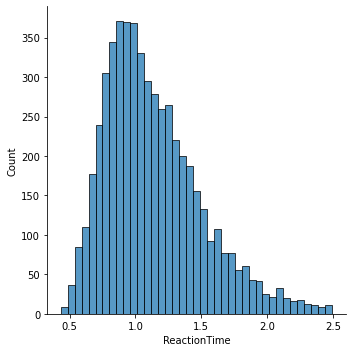

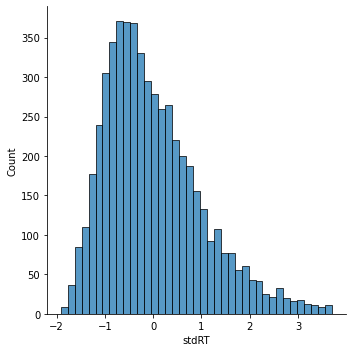

In [28]:
pl.figure(figsize = (20, 10))
sns.displot(eeg_clean['ReactionTime'])
sns.displot(eeg_clean['stdRT']);

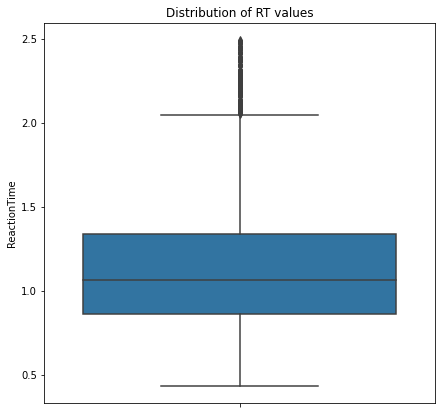

In [29]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="ReactionTime", data=eeg_clean)
pl.title("Distribution of RT values");

Outliers

In [30]:
# check for outliers outside 
eeg_no_outliers = eeg_clean.copy()
q75 = np.percentile(eeg_no_outliers['ReactionTime'], 75)
q25 = np.percentile(eeg_no_outliers['ReactionTime'], 25)
inter_qr = q75 - q25
upper = q75 + (inter_qr*1.5)
lower = q25 - (inter_qr*1.5)
col_new = []
for value in eeg_no_outliers['ReactionTime'].values:
  if value < lower:
    col_new.append(np.nan)
  elif value > upper:
    col_new.append(np.nan)
  else:
    col_new.append(value)
eeg_no_outliers['ReactionTime'] = col_new

In [31]:
eeg_no_outliers[eeg_no_outliers['ReactionTime'].isna()].Subject.unique()
# outliers across most of the subjects

array(['E2', 'E3', 'E4', 'E5', 'E6', 'E8', 'E10', 'E11', 'E13', 'E15',
       'E16', 'E17', 'E18', 'E20', 'E21', 'E22', 'E23', 'E24', 'E26',
       'E27', 'E28', 'E29', 'E30', 'E33'], dtype=object)

In [32]:
print(eeg_no_outliers.isnull().sum()['ReactionTime'])
# drop outliers
eeg_no_outliers = eeg_no_outliers.dropna()
print(eeg_no_outliers.isnull().sum()['ReactionTime'])

134
0


In [33]:
# redo standardization with new values 
rt = eeg_no_outliers.ReactionTime.values
eeg_no_outliers['stdRT'] = (rt - rt.mean())/rt.std()

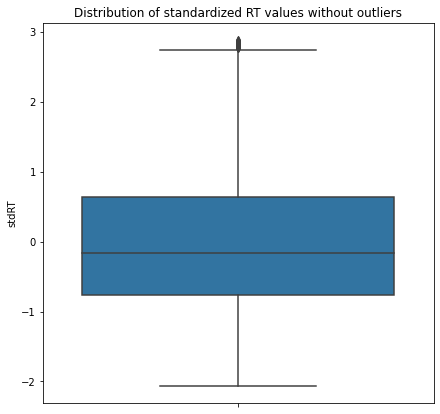

In [34]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="stdRT", data=eeg_no_outliers)
pl.title("Distribution of standardized RT values without outliers");

<Figure size 1440x720 with 0 Axes>

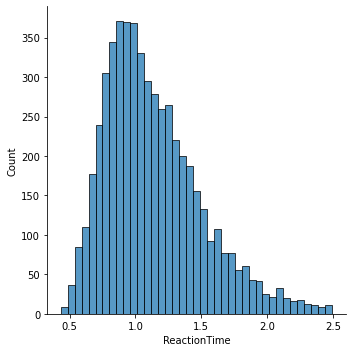

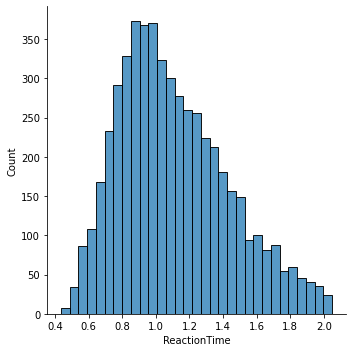

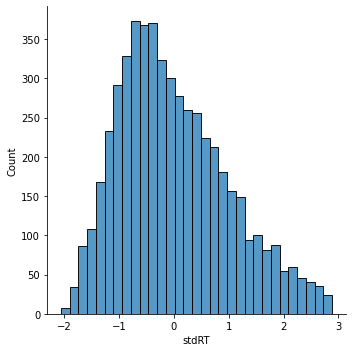

In [35]:
# upper plot - with outliers, lower plots - without
pl.figure(figsize = (20, 10))
sns.displot(eeg_clean['ReactionTime']);
sns.displot(eeg_no_outliers['ReactionTime']);
sns.displot(eeg_no_outliers['stdRT']);

Creating columns for dummy coding of lexical and phono variables 

In [62]:
lex = []
phon = []
for i in eeg_no_outliers.ProbeCategory.values:
  if 'non-words' in i: # non - words = 0, words = 0
    lex.append(0)
  elif 'words' in i:
    lex.append(1)
for i in eeg_no_outliers.ProbeCategory.values:
  if 'low' in i: # low = 1 high = 0
    phon.append(1)
  elif 'high' in i:
    phon.append(0)
print(len(lex))
print(len(phon))

5334
5334


In [63]:
eeg_no_outliers['Lex'] = lex
eeg_no_outliers['Phono'] = phon

## Plotting the accuracy across conditions

In [64]:
eeg_no_outliers.head()

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,...,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx,CorrPercentage,Position,Length,stdRT,Lex,Phono
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,...,low non-words,"[array(['yuf.wav'], dtype='<U7'), array(['JcG....",ycG.wav,"[39, 32, 35, 37, 38]",0.875,3,5,0.535034,0,1
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,...,low words,"[[array(['tub.wav'], dtype='<U7')]\n [array(['...",yuT.wav,"[27, 23, 22, 24, 25, 29, 26, 28, 30]",0.875,3,9,-0.366749,1,1
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,...,high words,"[array(['fEl.wav'], dtype='<U7'), array(['lEr....",lEr.wav,"[2, 5, 8, 4, 6]",0.875,1,5,1.474424,1,0
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,...,high non-words,"[[array(['gWT.wav'], dtype='<U7')]\n [array(['...",g@n.wav,"[34, 35, 36, 40, 39, 33, 37]",0.875,0,7,0.234390,0,0
5,5,E2,1,2,16,in_sequence,High Non-Words,1.566338,2.Left,Yes,...,high non-words,"[[array(['g@n.wav'], dtype='<U7')]\n [array(['...",kYl.wav,"[13, 15, 16, 20, 11, 18, 12, 19, 17]",0.875,1,9,1.405773,0,0


In [392]:
eeg_no_outliers.groupby(['ProbeType'])[['ResponseCorrect']].mean()

,ResponseCorrect
ProbeType,
1,0.849294
2,0.899742


In [419]:
ss = eeg_no_outliers[eeg_no_outliers['ProbeType'] == 1][['ProbeCategory', 'StimulusCategory']]

In [420]:
ss.head()

,ProbeCategory,StimulusCategory
4,high non-words,Low Non-words
6,low words,High Words
10,high non-words,High Non-Words
13,low words,High Words
14,low words,High Words


In [421]:
new_p = []
new_s = []
for i in ss.ProbeCategory.values:
  new_p.append(i.lower())
for i in ss.StimulusCategory.values:
  new_s.append(i.lower())
print(len(new_p))
print(len(new_s))

2621
2621


In [422]:
ss['ProbeCategory'] = new_p
ss['StimulusCategory'] = new_s

In [423]:
ss.head()

,ProbeCategory,StimulusCategory
4,high non-words,low non-words
6,low words,high words
10,high non-words,high non-words
13,low words,high words
14,low words,high words


In [427]:
index = 0
check = []
for i in range(0, ss.shape[0]):
  if 'non-words' in new_p[i]:
    if 'non-words' in new_s[i]:
      index += 1 
    else:
      index += 1
      check.append(i)
  else:
    if 'non-words' in new_s[i]:
      index += 1
      check.append(i)
    else:
      index += 1
print(index)
print(check)

2621
[]


**General plots**

In [39]:
only_match = eeg_no_outliers[eeg_no_outliers['ProbeType'] == 2]
only_mismatch = eeg_no_outliers[eeg_no_outliers['ProbeType'] == 1]

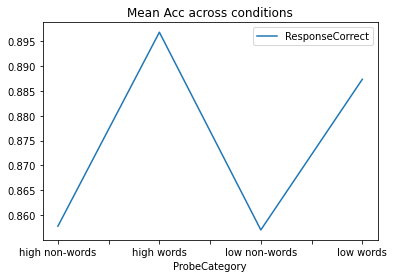

In [40]:
eeg_no_outliers.groupby(['ProbeCategory'])['ResponseCorrect'].mean().plot(
    legend=True, title = 'Mean Acc across conditions'
    );

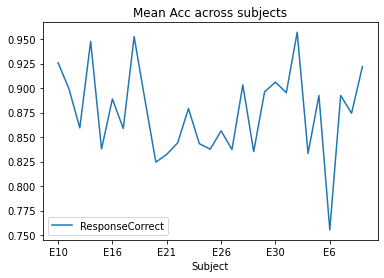

In [41]:
eeg_no_outliers.groupby(['Subject'])['ResponseCorrect'].mean().plot(
    legend=True, title = 'Mean Acc across subjects'
    );

In [49]:
sns.set()

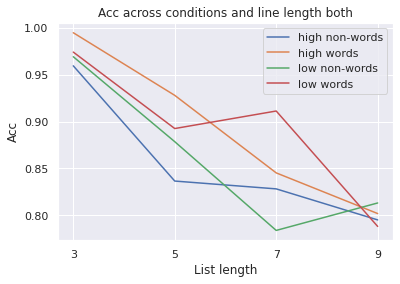

In [50]:
# ALL TOGETHER
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
acc_count = lambda v: sum(v) / v.count()
pl.figure()
subset = eeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].apply(
    acc_count
).reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length both');  

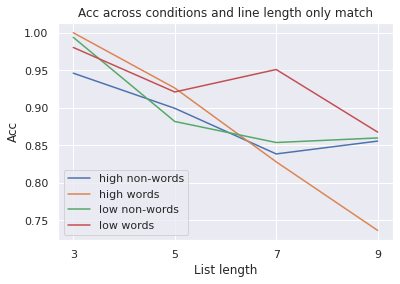

In [51]:
# WHEN MATCH
# plotting categories across condition when the probe is in sequence
pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only match');  

In [53]:
eeg_no_outliers.groupby(['ProbeCategory'])[['ResponseCorrect']].mean()

,ResponseCorrect
ProbeCategory,
high non-words,0.857784
high words,0.896797
low non-words,0.857034
low words,0.887324


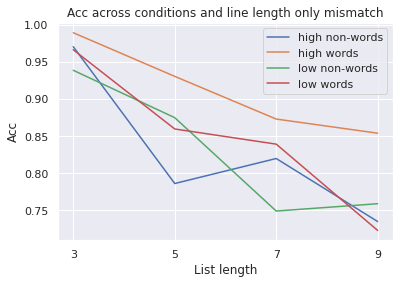

In [52]:
# WHEN MISMATCH
pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only mismatch');  

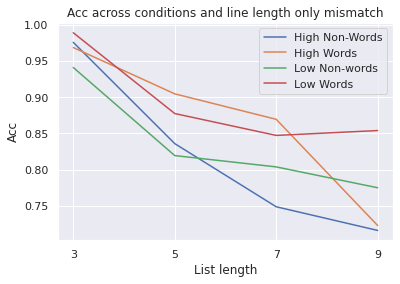

In [55]:
# WHEN MISMATCH
pl.figure()
subset = only_mismatch.groupby(['StimulusCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.StimulusCategory.unique())
pl.title('Acc across conditions and line length only mismatch');  

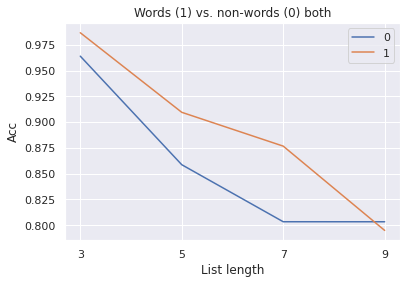

In [56]:
# W VS. NW FOR BOTH MATCH AND MISMATCH
pl.figure()
words_nonwords = eeg_no_outliers.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean(). reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words (1) vs. non-words (0) both');  

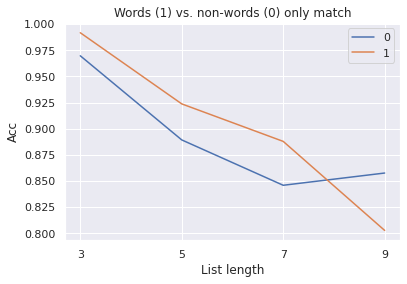

In [57]:
# ONLY MATCH W vs. NW
pl.figure()
words_nonwords = only_match.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean(). reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words (1) vs. non-words (0) only match');  

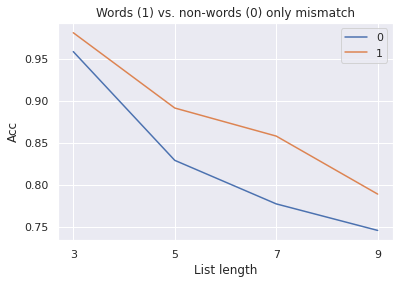

In [58]:
# ONLY MISMATCH W vs. NW
words_nonwords = only_mismatch.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean(). reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words (1) vs. non-words (0) only mismatch');  

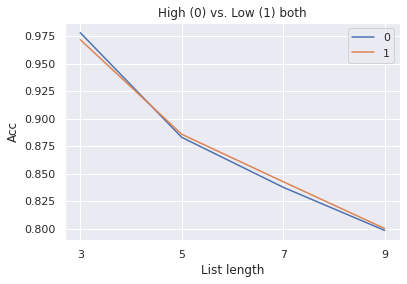

In [65]:
# H vs L both match and mismatch
pl.figure()
high_low = eeg_no_outliers.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean(). reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(high_low.Phono.unique())
pl.title('High (0) vs. Low (1) both');  

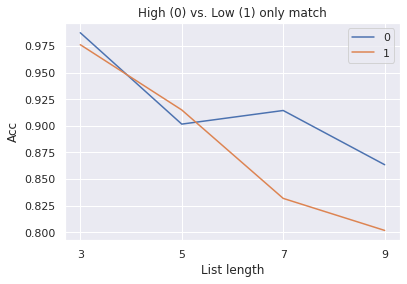

In [66]:
# H vs L ONLY MATCH
pl.figure()
high_low = only_match.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean(). reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(high_low.Phono.unique())
pl.title('High (0) vs. Low (1) only match');  

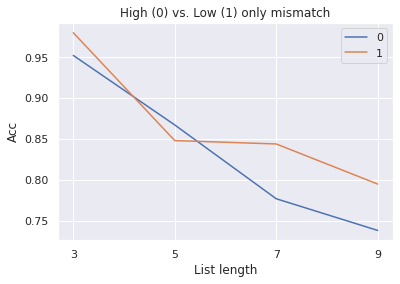

In [67]:
# H vs L ONLY MISMATCH
pl.figure()
high_low = only_mismatch.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean(). reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(high_low.Phono.unique())
pl.title('High (0) vs. Low (1) only mismatch');  

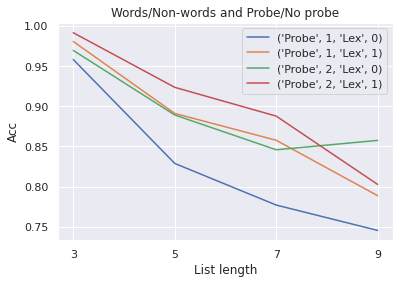

In [157]:
probe_words = eeg_no_outliers.groupby(['ProbeType', 'Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in probe_words.ProbeType.unique():
  for j in probe_words.Lex.unique():
    x = probe_words[(probe_words['ProbeType'] == i) & (probe_words['Lex'] == j)]
    pl.plot(x.Length, x.ResponseCorrect, label = ('Probe', i, 'Lex', j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words/Non-words and Probe/No probe');

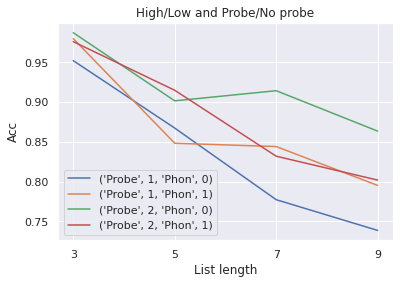

In [160]:
probe_neig = eeg_no_outliers.groupby(['ProbeType', 'Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in probe_neig.ProbeType.unique():
  for j in probe_neig.Phono.unique():
    x = probe_neig[(probe_neig['ProbeType'] == i) & (probe_neig['Phono'] == j)]
    pl.plot(x.Length, x.ResponseCorrect, label = ('Probe', i, 'Phon', j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High/Low and Probe/No probe');

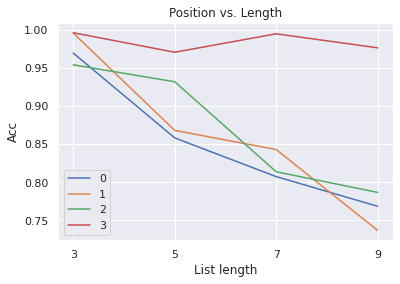

In [110]:
subset = eeg_no_outliers.groupby(['Position', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Position.unique():
  x = subset[subset['Position'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.Position.unique())
pl.title('Position vs. Length');

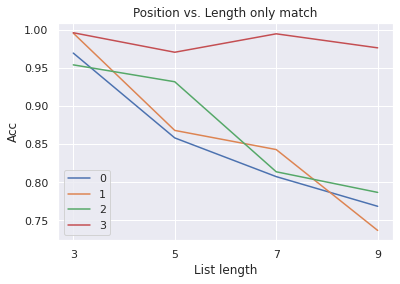

In [163]:
subset = eeg_no_outliers.groupby(['Position', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Position.unique():
  x = subset[subset['Position'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.Position.unique())
pl.title('Position vs. Length only match');

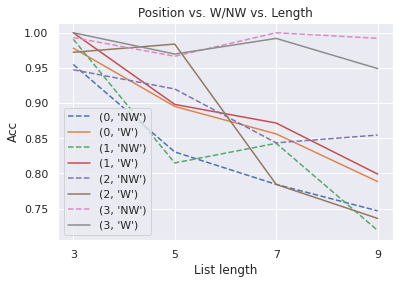

In [111]:
subset = eeg_no_outliers.groupby(['Position', 'Length', 'ProbeCategory'])[['ResponseCorrect']].mean().reset_index()
pos_words = subset.copy()
new_cat = []
cat = pos_words.ProbeCategory.values
for i in cat:
  if 'non-words' in i:
    new_cat.append('NW')
  elif 'words' in i:
    new_cat.append('W')
  else:
    print("Check")
pos_words['ProbeCategory'] = new_cat

pos_words = pos_words.groupby(['Position', 'ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()

for i in pos_words.Position.unique():
  for j in pos_words.ProbeCategory.unique():
    x = pos_words[(pos_words['Position'] == i) & (pos_words['ProbeCategory'] == j)]
    if j == 'NW':
      pl.plot(x.Length, x.ResponseCorrect, '--', label = (i, j))
    elif j == 'W':
      pl.plot(x.Length, x.ResponseCorrect, label = (i, j))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Position vs. W/NW vs. Length');

## Plotting accuracy distributions per subject

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

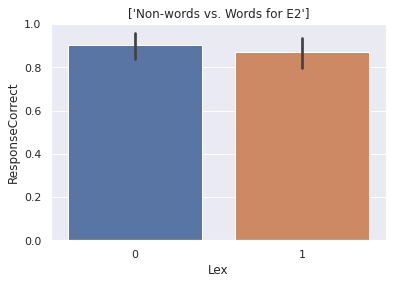

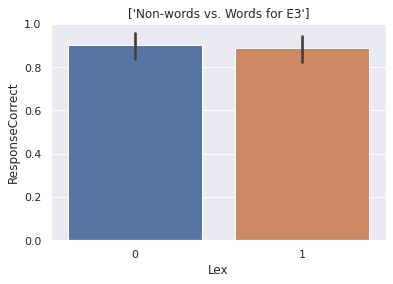

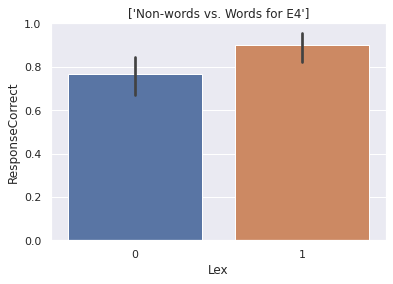

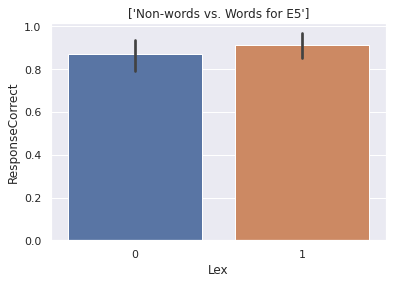

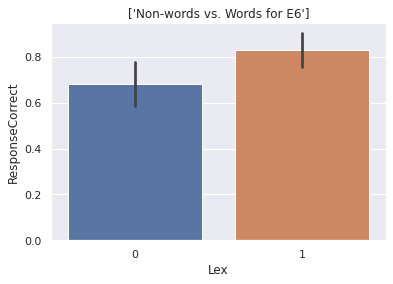

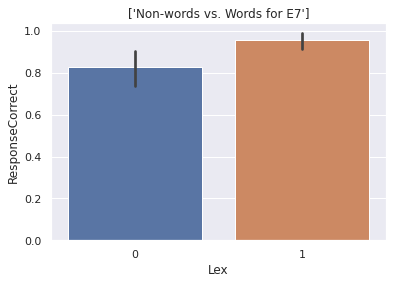

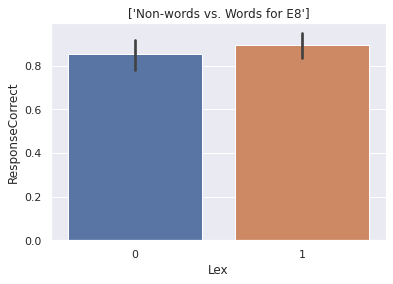

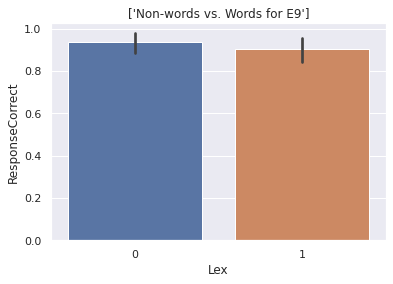

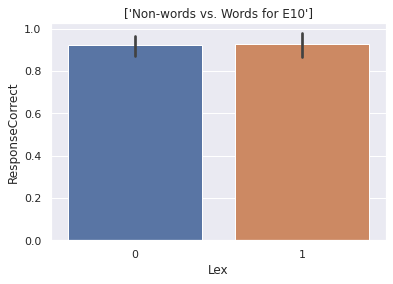

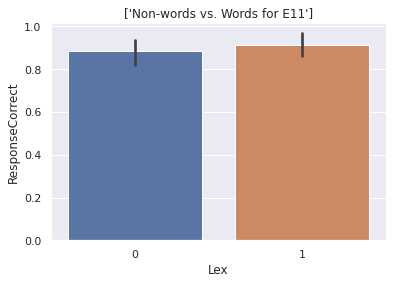

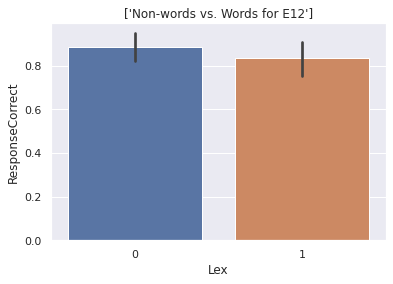

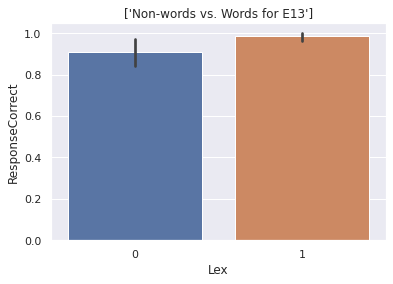

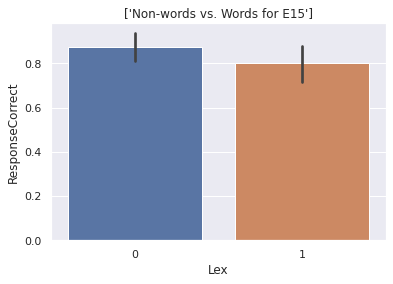

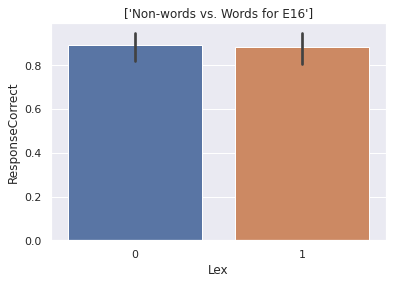

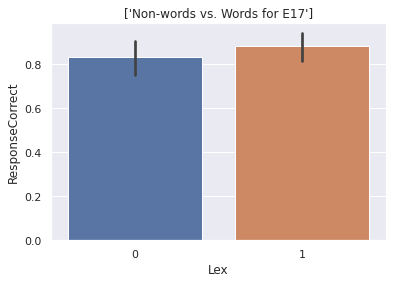

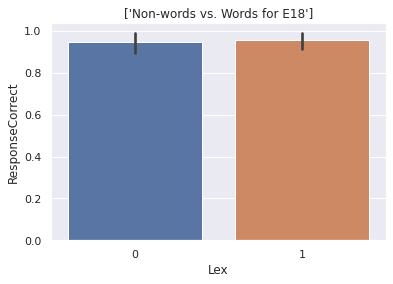

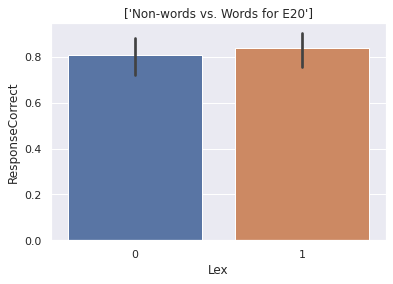

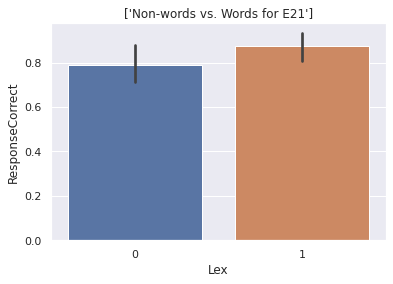

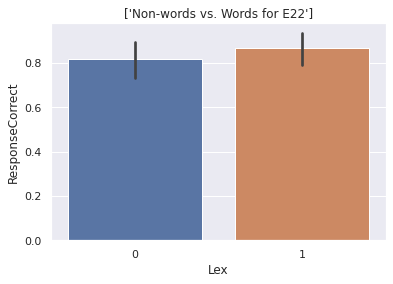

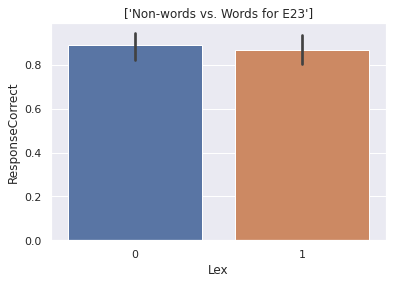

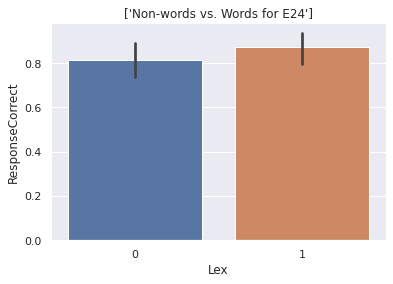

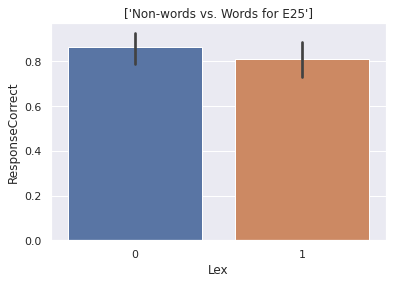

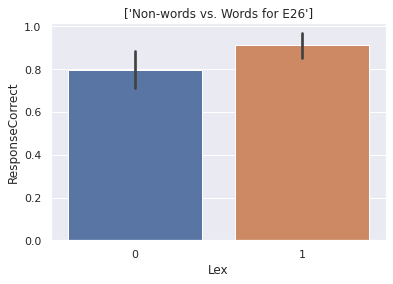

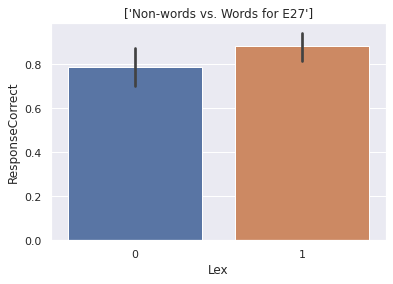

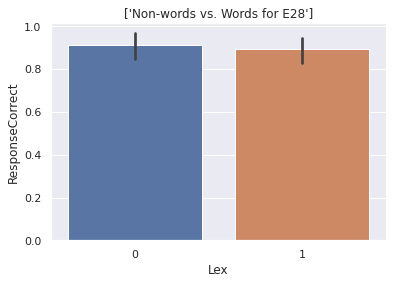

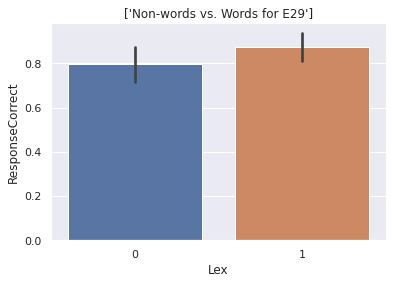

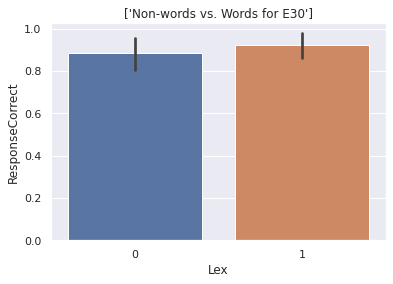

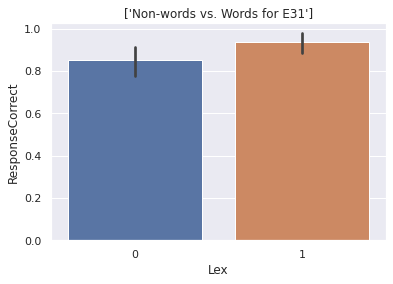

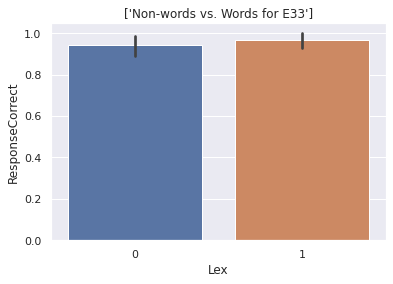

In [68]:
for i in eeg_no_outliers.Subject.unique():
  subset = eeg_no_outliers[eeg_no_outliers['Subject'] == i]
  pl.figure()
  sns.barplot(x = 'Lex', y = 'ResponseCorrect', data = subset, estimator = lambda x: sum(x)/len(x));
  pl.title('Non-words vs. Words for ' + subset.Subject.unique());

In [92]:
sample = eeg_no_outliers[eeg_no_outliers['Subject'] == 'E26']
sample = sample[[
                 'Lex', 'ResponseCorrect', 'ProbeType'
]]

In [91]:
x = sample[sample['Lex'] == 1]
y = sample[sample['Lex'] == 0]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([       inf, 2.30772689]), pvalue=array([0.        , 0.02224993]))

In [94]:
x = sample[(sample['Lex'] == 1) & (sample['ProbeType'] == 1)]
y = sample[(sample['Lex'] == 0) & (sample['ProbeType'] == 1)]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([       inf, 2.29515493,        nan]), pvalue=array([0.        , 0.02398409,        nan]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

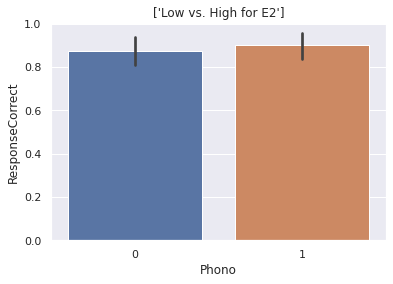

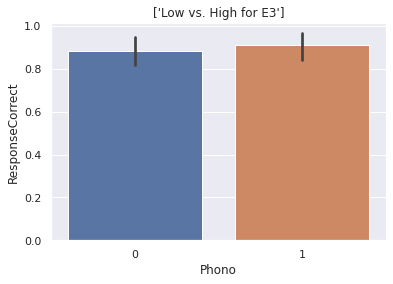

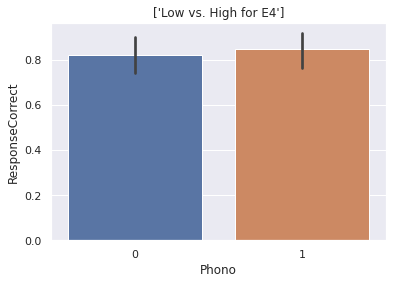

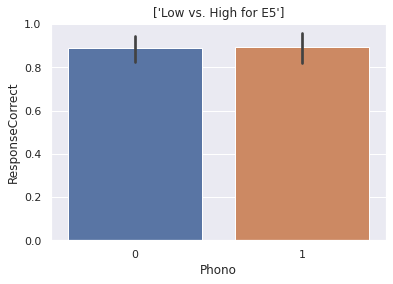

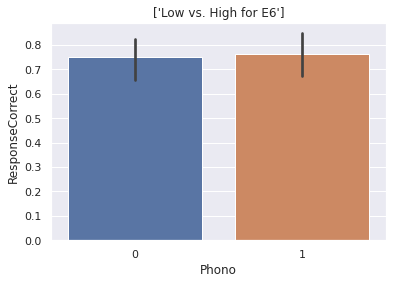

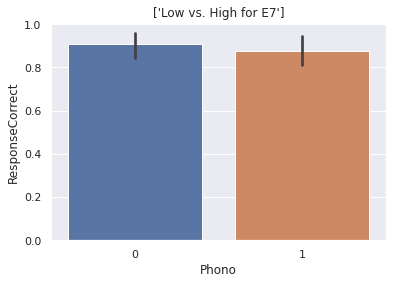

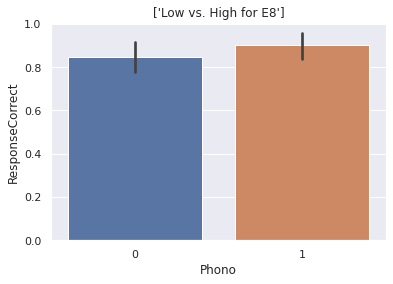

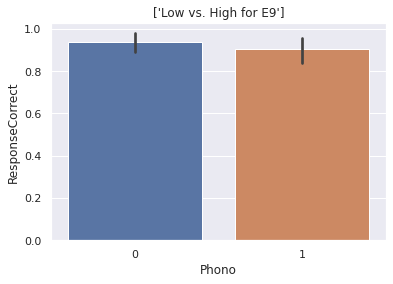

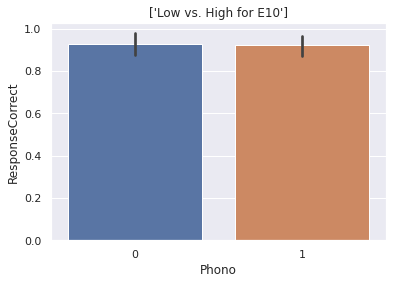

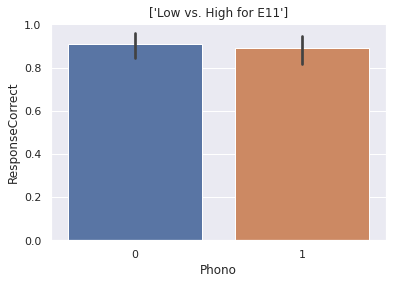

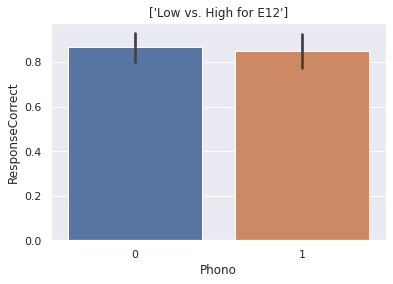

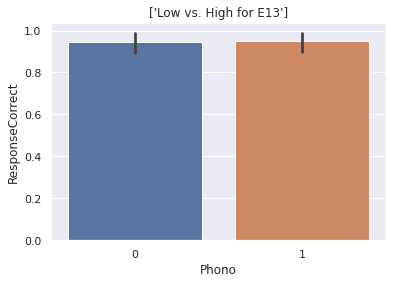

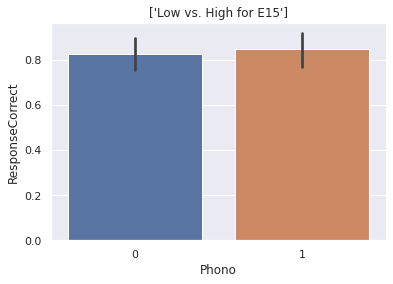

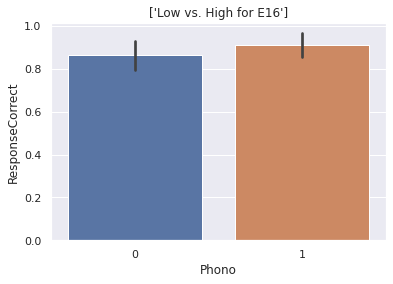

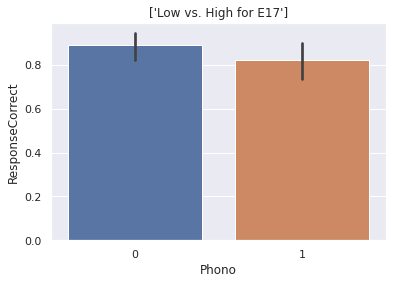

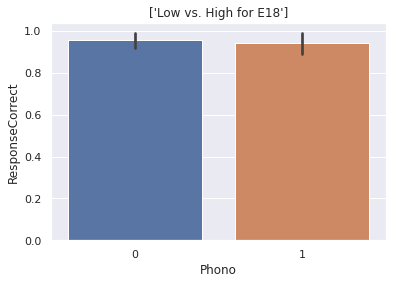

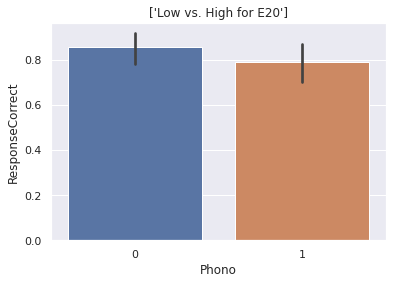

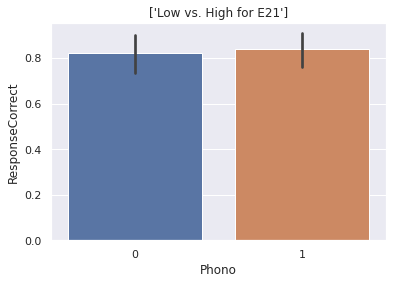

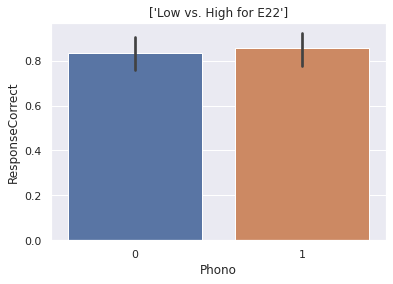

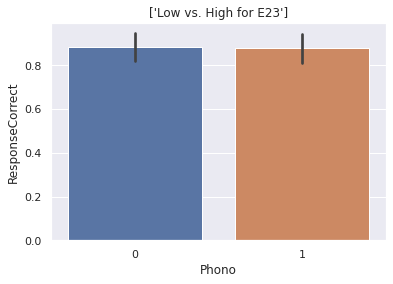

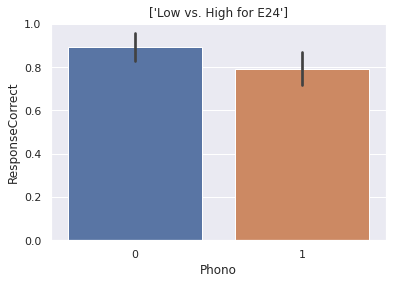

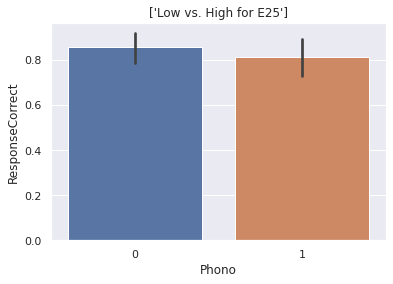

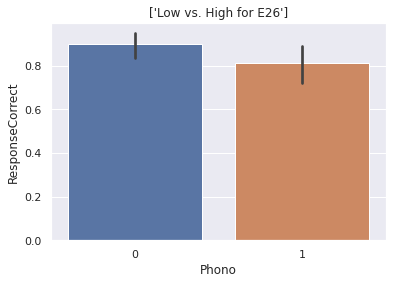

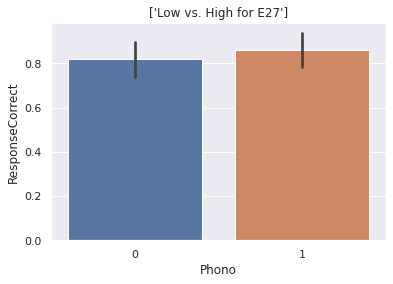

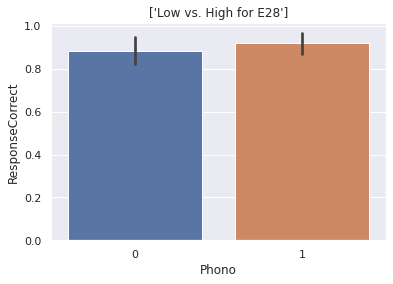

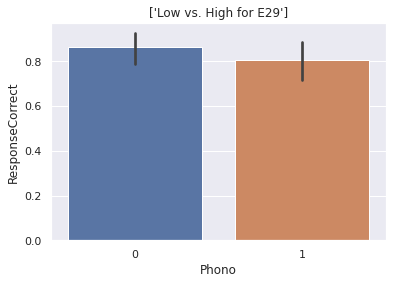

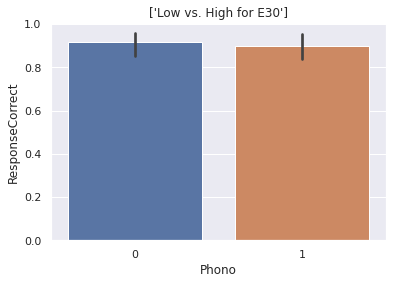

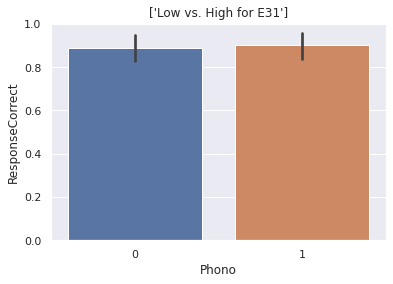

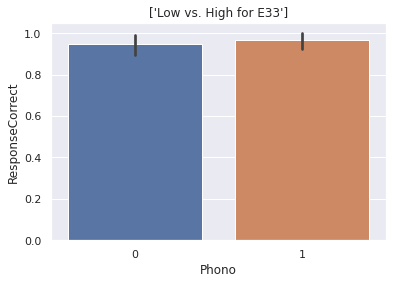

In [95]:
for i in eeg_no_outliers.Subject.unique():
  subset = eeg_no_outliers[eeg_no_outliers['Subject'] == i]
  pl.figure();
  sns.barplot(x = 'Phono', y = 'ResponseCorrect', data = subset, estimator = lambda x: sum(x)/len(x));
  pl.title('Low vs. High for ' + subset.Subject.unique());

In [113]:
sample = eeg_no_outliers[eeg_no_outliers['Subject'] == 'E20']
sample = sample[[
                 'Phono', 'ResponseCorrect'
]]

In [114]:
x = sample[sample['Phono'] == 1]
y = sample[sample['Phono'] == 0]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([        inf, -1.15367794]), pvalue=array([0.        , 0.25017661]))

In [115]:
sample = eeg_no_outliers[eeg_no_outliers['Subject'] == 'E20']
sample = sample[[
                 'Phono', 'ResponseCorrect', 'ProbeType'
]]

In [116]:
x = sample[(sample['Phono'] == 1) & (sample['ProbeType'] == 1)]
y = sample[(sample['Phono'] == 0) & (sample['ProbeType'] == 1)]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([        inf, -2.25676732,         nan]), pvalue=array([0.        , 0.02726415,        nan]))

In [117]:
x = sample[(sample['Phono'] == 1) & (sample['ProbeType'] == 2)]
y = sample[(sample['Phono'] == 0) & (sample['ProbeType'] == 2)]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([       inf, 0.39463818,        nan]), pvalue=array([0.        , 0.69400415,        nan]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

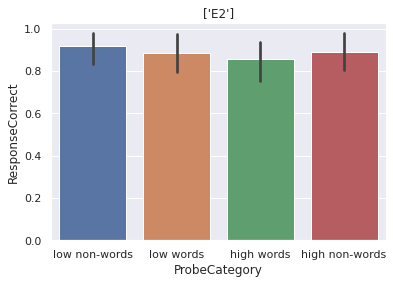

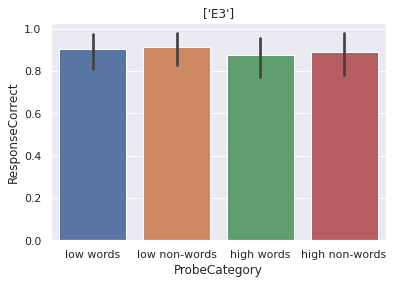

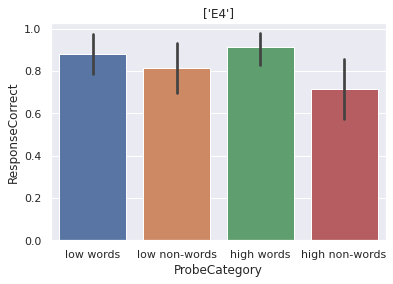

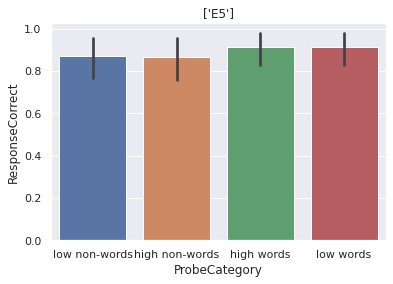

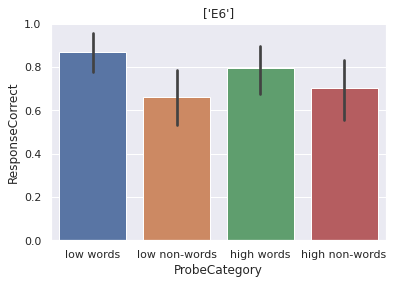

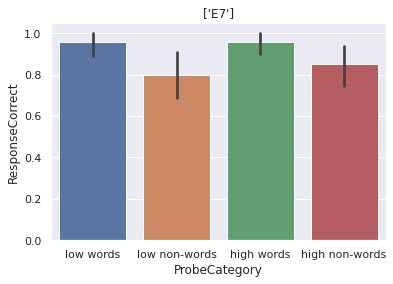

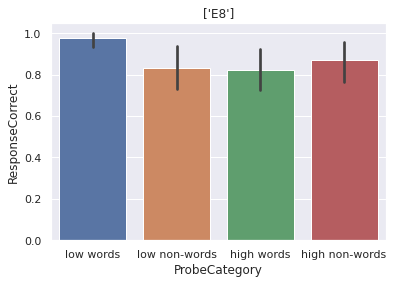

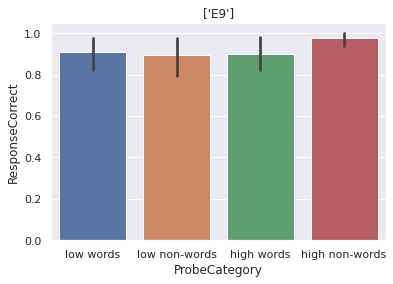

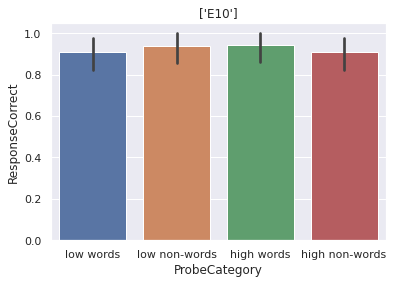

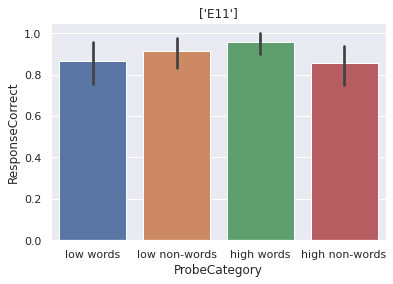

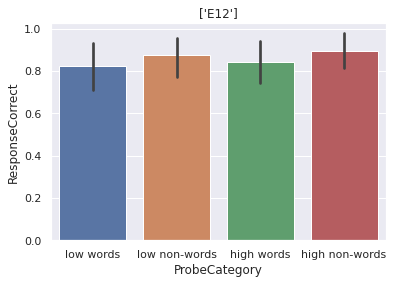

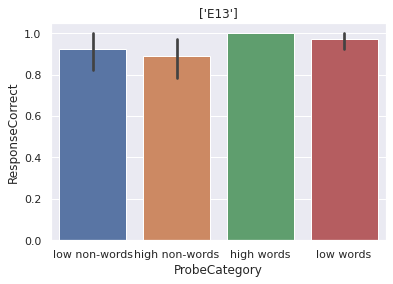

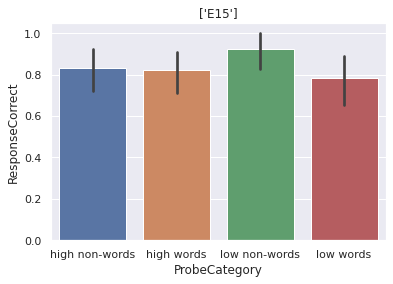

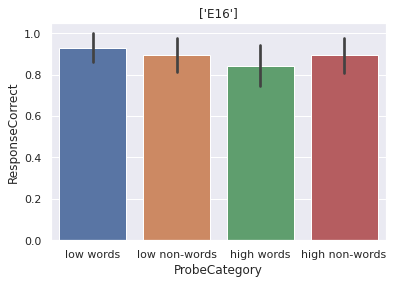

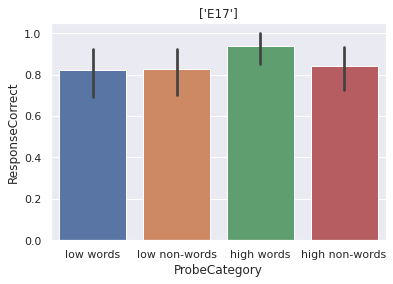

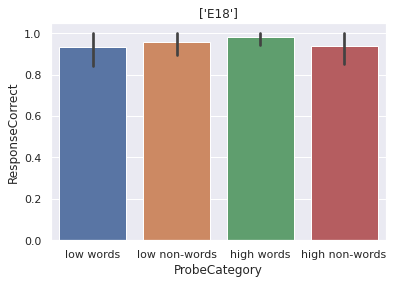

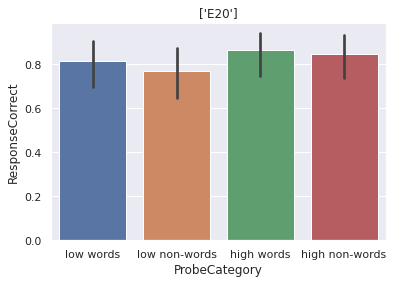

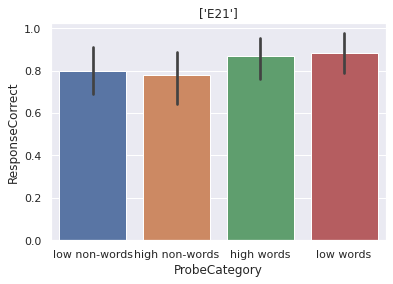

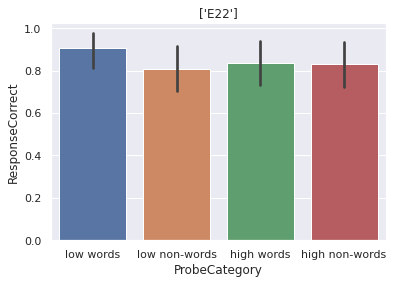

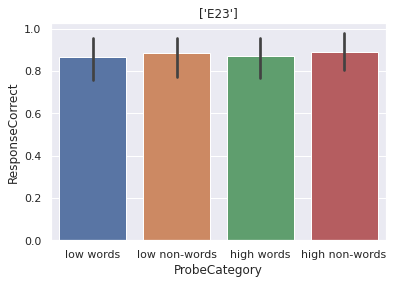

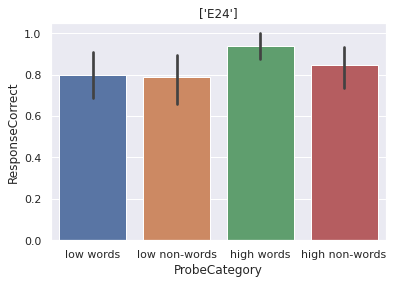

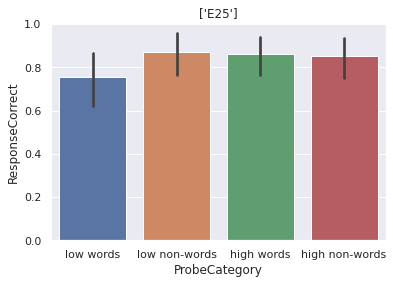

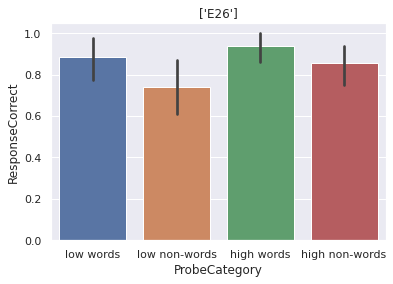

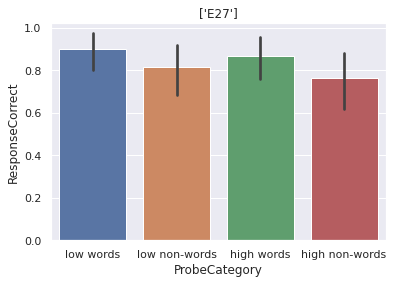

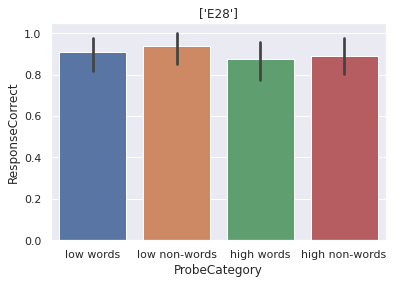

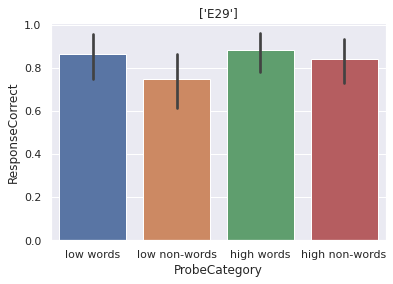

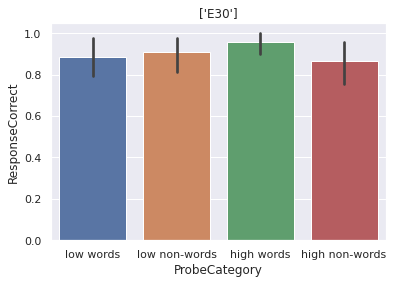

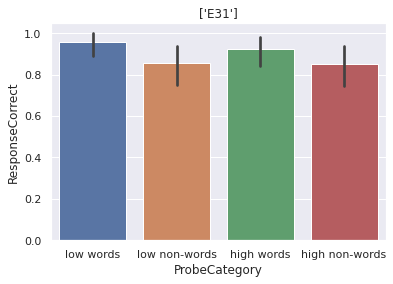

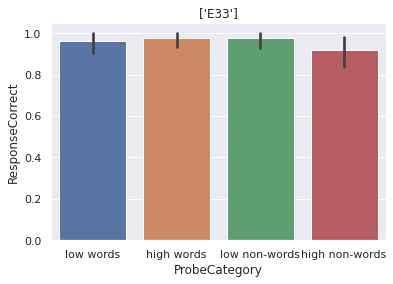

In [118]:
for i in eeg_no_outliers.Subject.unique():
  subset = eeg_no_outliers[eeg_no_outliers['Subject'] == i]
  pl.figure();
  sns.barplot(x = 'ProbeCategory', y = 'ResponseCorrect', data = subset, estimator = lambda x: sum(x)/len(x));
  pl.title(subset.Subject.unique());

In [244]:
sample = eeg_no_outliers[eeg_no_outliers['Subject'] == 'E29']
sample = sample[[
                 'ProbeCategory', 'ResponseCorrect', 'ProbeType'
]]

In [245]:
x = sample[sample['ProbeCategory'] == 'low words']['ResponseCorrect'].values
y = sample[sample['ProbeCategory'] == 'low non-words']['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=1.3486848892999648, pvalue=0.1811632496660115)

In [246]:
x = sample[sample['ProbeCategory'] == 'high words']['ResponseCorrect'].values
y = sample[sample['ProbeCategory'] == 'high non-words']['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=0.5386708466829421, pvalue=0.5914944390750965)

In [247]:
x = sample[sample['ProbeCategory'] == 'high words']['ResponseCorrect'].values
y = sample[sample['ProbeCategory'] == 'low words']['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=0.23391172014661546, pvalue=0.8155909800759706)

In [248]:
x = sample[sample['ProbeCategory'] == 'high non-words']['ResponseCorrect'].values
y = sample[sample['ProbeCategory'] == 'low non-words']['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=1.0517173216976332, pvalue=0.2959576035007151)

In [249]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 2)]['ResponseCorrect'].values
y = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 2)]['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=1.4529663145135576, pvalue=0.16254999902972705)

In [250]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 1)]['ResponseCorrect'].values
y = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 1)]['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=0.5145823460933409, pvalue=0.6095923703182808)

In [251]:
x = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 2)]['ResponseCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 2)]['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=0.3632696097723631, pvalue=0.7183192621588683)

In [252]:
x = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 1)]['ResponseCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 1)]['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=0.34081843441952303, pvalue=0.7349045263352828)

In [253]:
x = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 2)]['ResponseCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 2)]['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=0.41126568769515837, pvalue=0.6831523583536006)

In [254]:
x = sample[(sample['ProbeCategory'] == 'low non-words') & (sample['ProbeType'] == 1)]['ResponseCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high non-words') & (sample['ProbeType'] == 1)]['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-1.5551011186802937, pvalue=0.12719765000845462)

In [255]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 2)]['ResponseCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 2)]['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=1.7999999999999994, pvalue=0.08304492144795939)

In [256]:
x = sample[(sample['ProbeCategory'] == 'low words') & (sample['ProbeType'] == 1)]['ResponseCorrect'].values
y = sample[(sample['ProbeCategory'] == 'high words') & (sample['ProbeType'] == 1)]['ResponseCorrect'].values
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=-1.2677502948471508, pvalue=0.21325266184001385)

## Plotting the RT across conditions

In [257]:
eeg_no_outliers.head()

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,...,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx,CorrPercentage,Position,Length,stdRT,Lex,Phono
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,...,low non-words,"[array(['yuf.wav'], dtype='<U7'), array(['JcG....",ycG.wav,"[39, 32, 35, 37, 38]",0.875,3,5,0.535034,0,1
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,...,low words,"[[array(['tub.wav'], dtype='<U7')]\n [array(['...",yuT.wav,"[27, 23, 22, 24, 25, 29, 26, 28, 30]",0.875,3,9,-0.366749,1,1
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,...,high words,"[array(['fEl.wav'], dtype='<U7'), array(['lEr....",lEr.wav,"[2, 5, 8, 4, 6]",0.875,1,5,1.474424,1,0
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,...,high non-words,"[[array(['gWT.wav'], dtype='<U7')]\n [array(['...",g@n.wav,"[34, 35, 36, 40, 39, 33, 37]",0.875,0,7,0.234390,0,0
5,5,E2,1,2,16,in_sequence,High Non-Words,1.566338,2.Left,Yes,...,high non-words,"[[array(['g@n.wav'], dtype='<U7')]\n [array(['...",kYl.wav,"[13, 15, 16, 20, 11, 18, 12, 19, 17]",0.875,1,9,1.405773,0,0


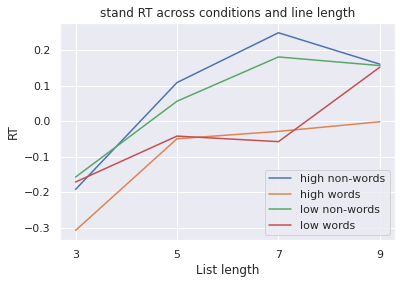

In [258]:
subset = eeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('stand RT across conditions and line length');  

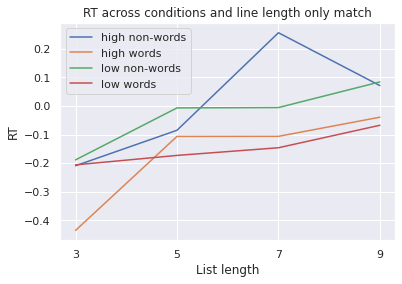

In [259]:
subset = only_match.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length only match');  

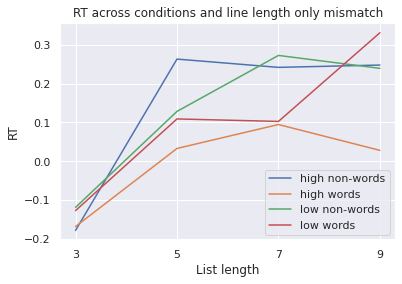

In [260]:
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length only mismatch');  

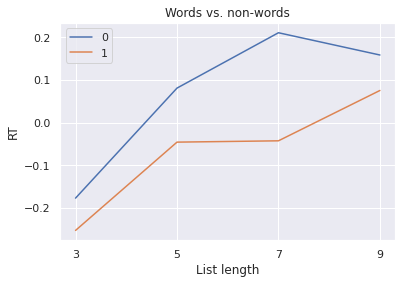

In [261]:
pl.figure()
words_nonwords = eeg_no_outliers.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words vs. non-words');  

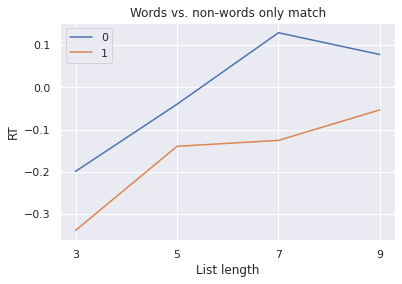

In [262]:
pl.figure()
words_nonwords = only_match.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words vs. non-words only match');  

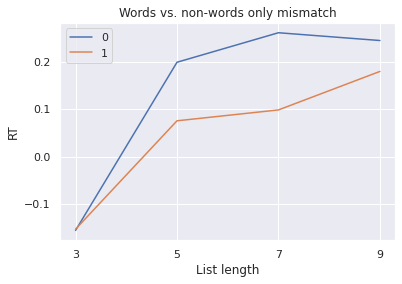

In [263]:
pl.figure()
words_nonwords = only_mismatch.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words vs. non-words only mismatch');  

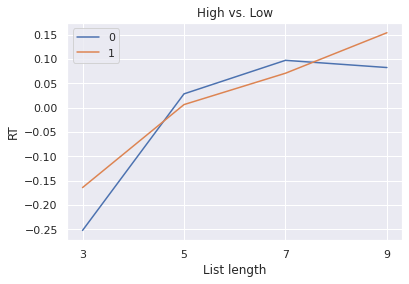

In [264]:
pl.figure()
high_low = eeg_no_outliers.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(high_low.Phono.unique())
pl.title('High vs. Low');  

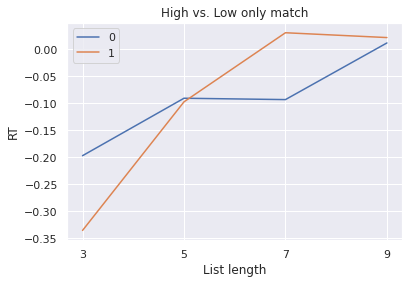

In [265]:
pl.figure()
high_low = only_match.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(high_low.Phono.unique())
pl.title('High vs. Low only match');  

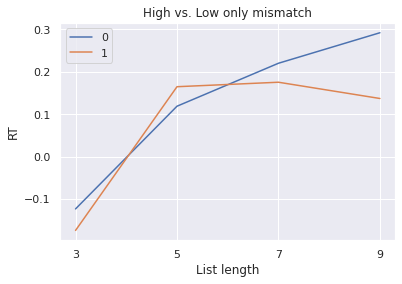

In [266]:
pl.figure()
high_low = only_mismatch.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in high_low.Phono.unique():
  x = high_low[high_low['Phono'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(high_low.Phono.unique())
pl.title('High vs. Low only mismatch');  

## Individual distributions of RT per subject

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

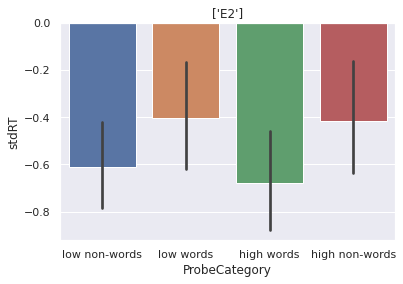

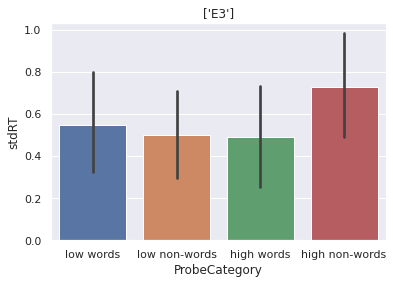

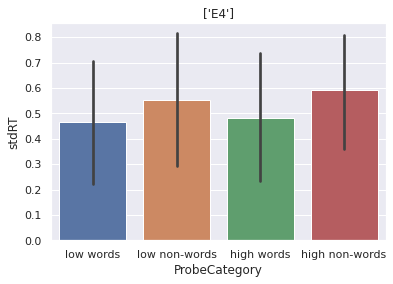

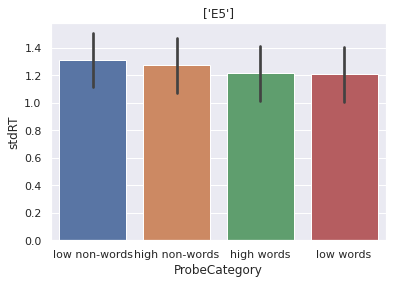

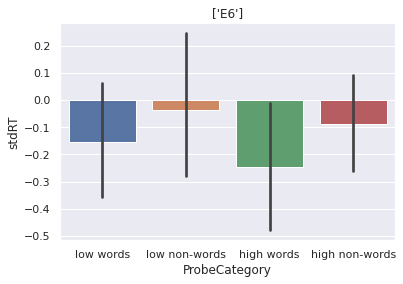

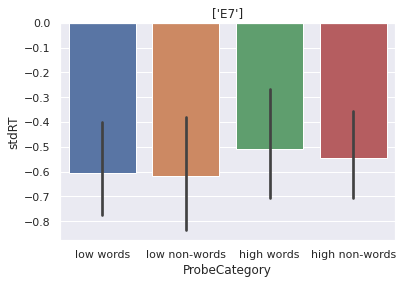

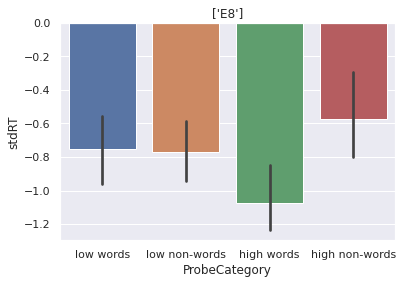

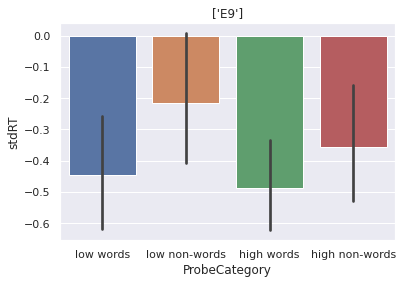

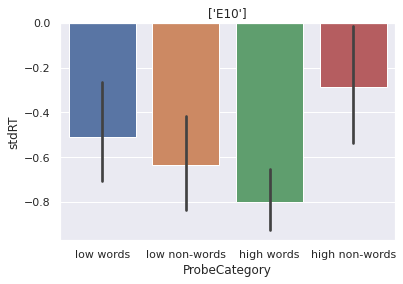

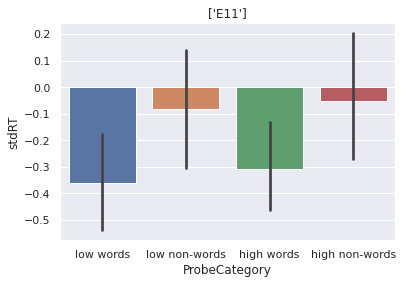

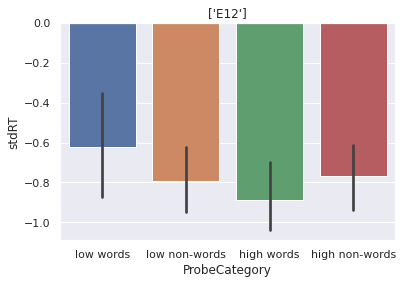

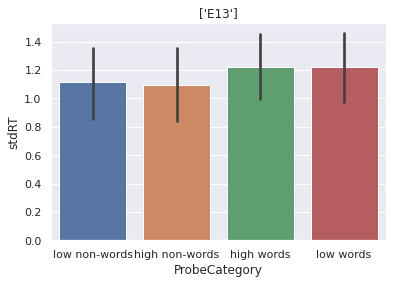

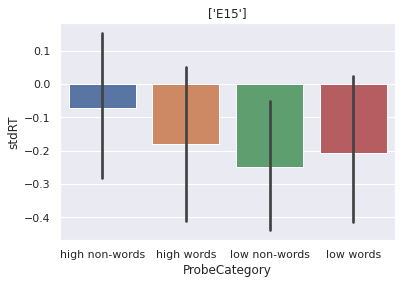

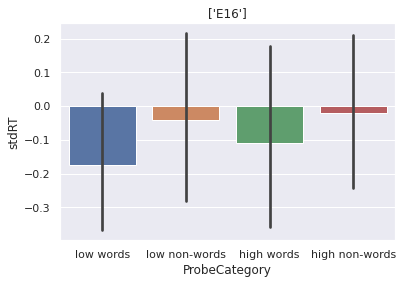

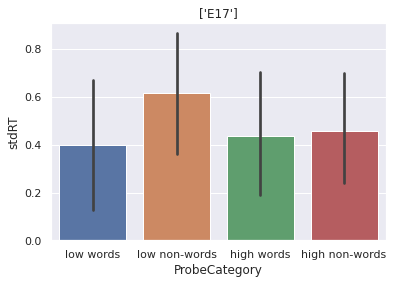

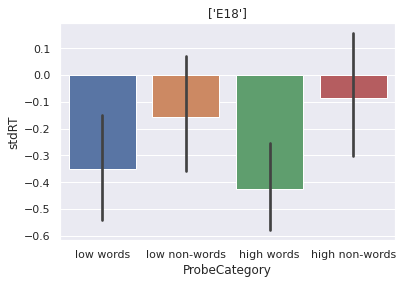

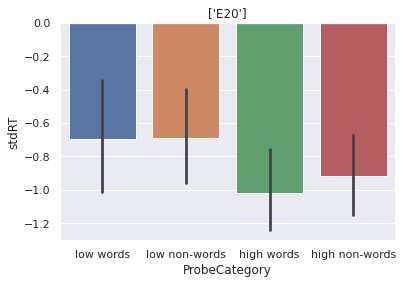

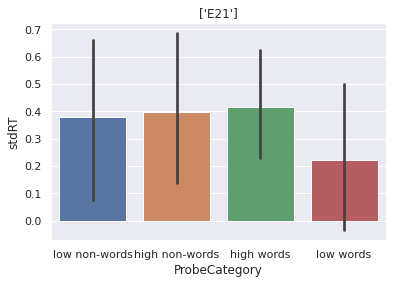

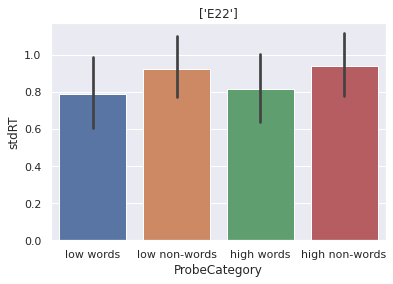

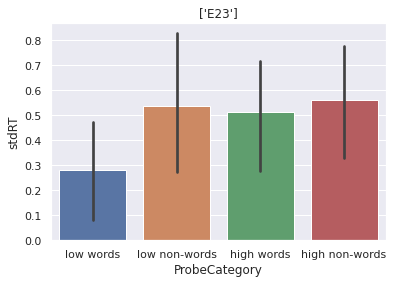

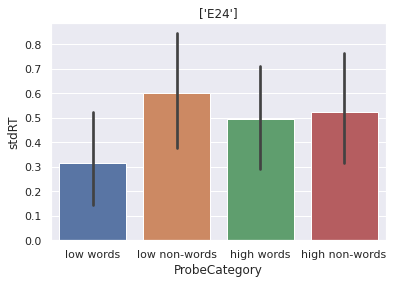

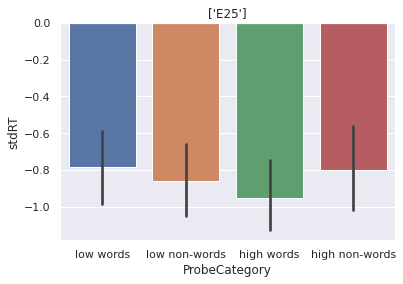

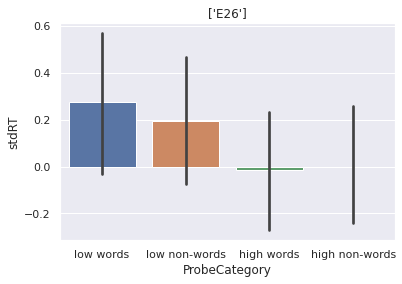

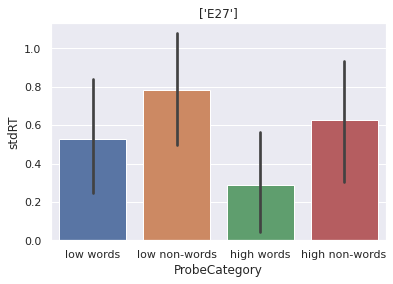

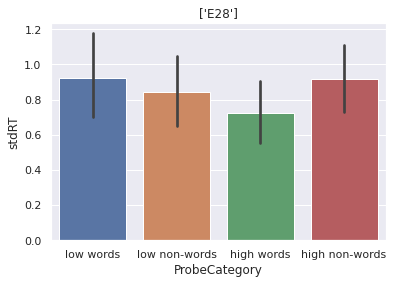

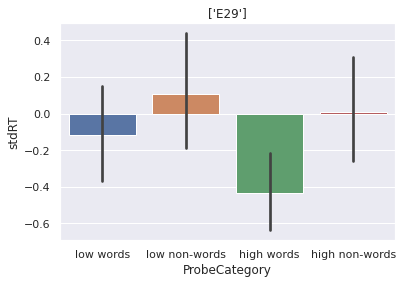

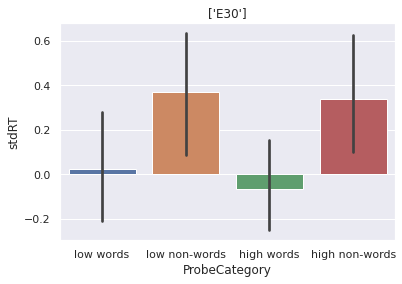

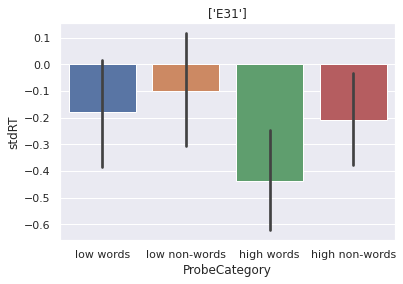

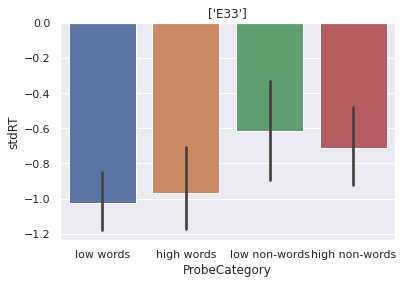

In [389]:
for i in eeg_no_outliers.Subject.unique():
  subset = eeg_no_outliers[eeg_no_outliers['Subject'] == i]
  pl.figure();
  sns.barplot(x = 'ProbeCategory', y = 'stdRT', data = subset, estimator = lambda x: sum(x)/len(x));
  pl.title(subset.Subject.unique());

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

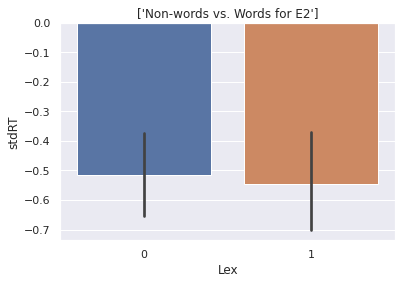

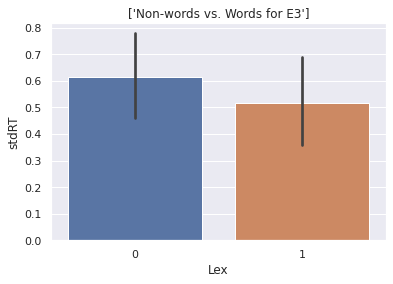

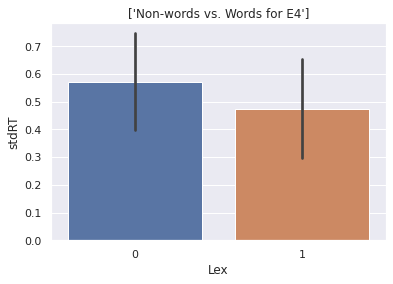

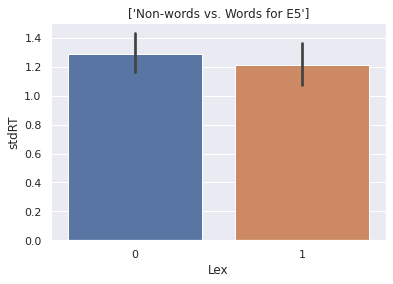

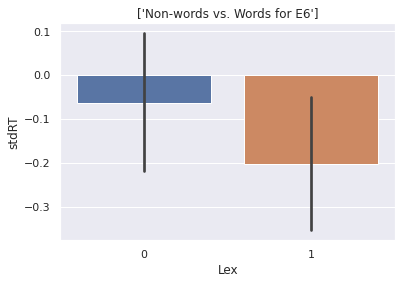

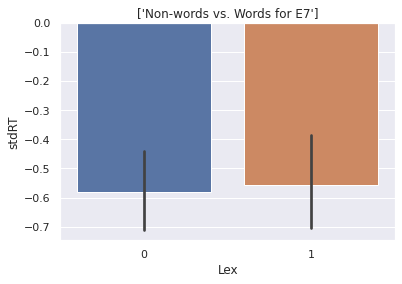

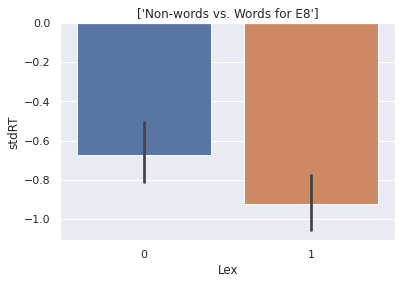

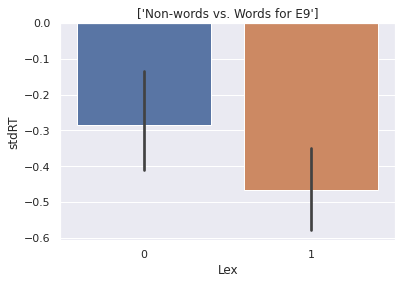

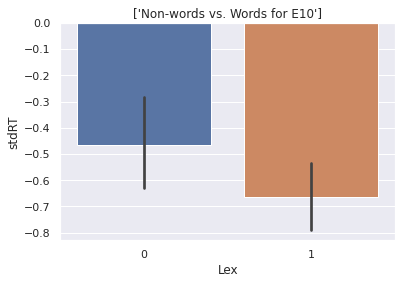

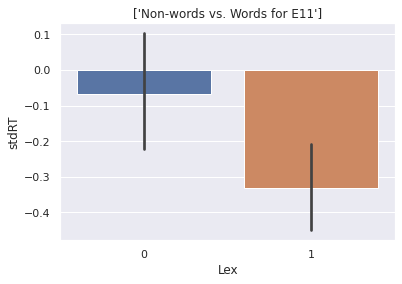

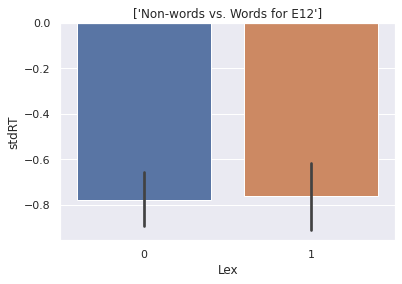

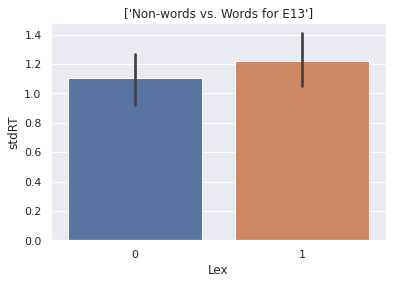

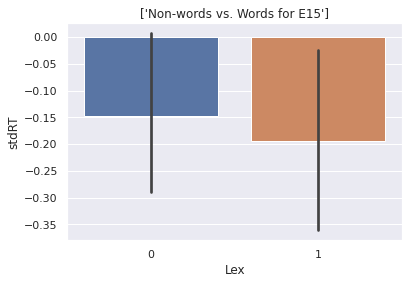

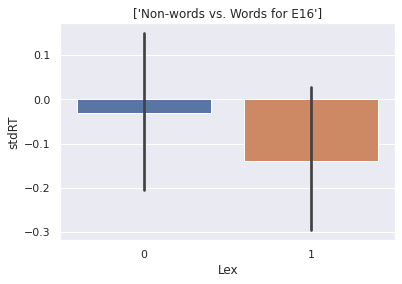

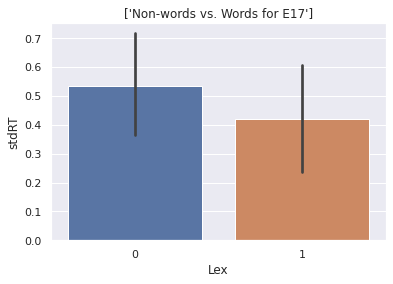

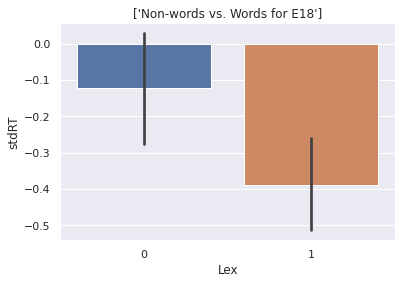

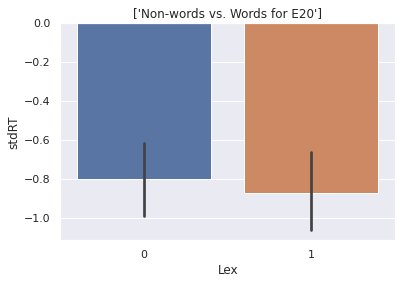

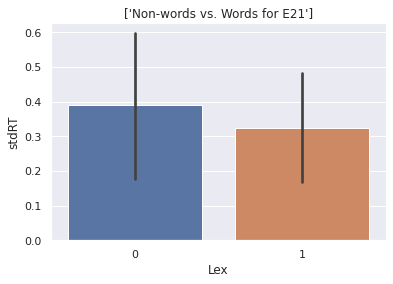

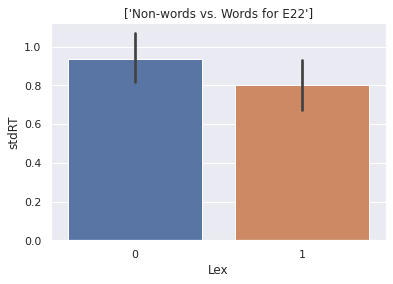

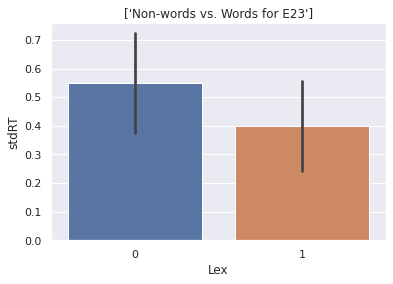

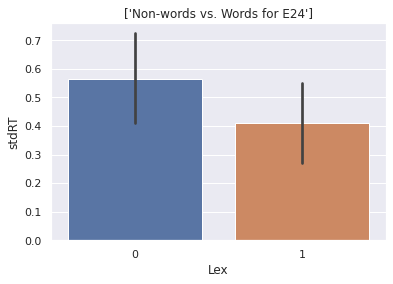

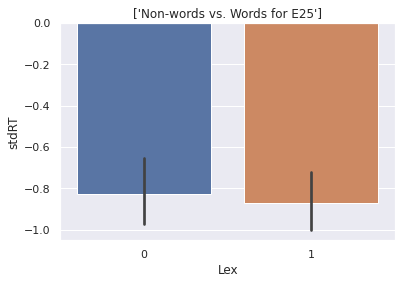

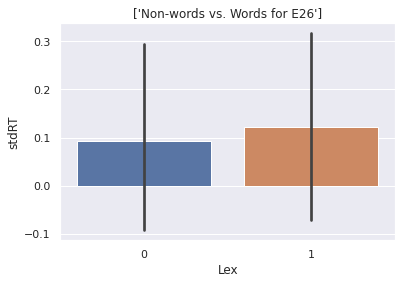

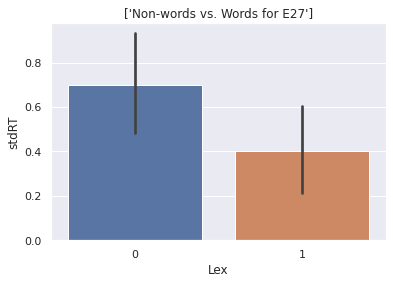

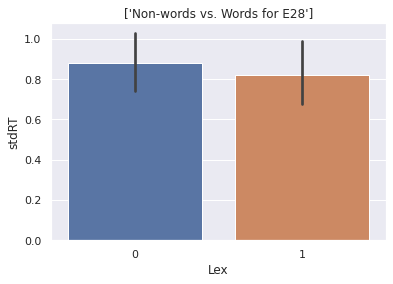

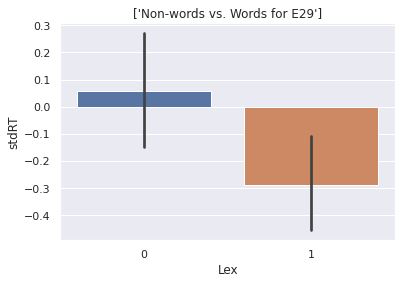

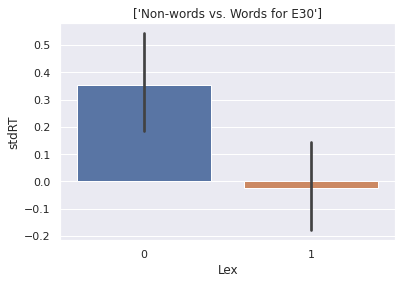

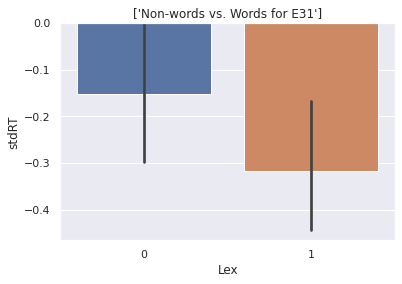

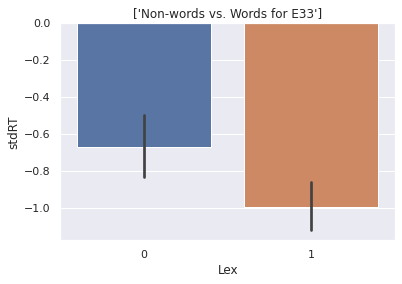

In [268]:
for i in eeg_no_outliers.Subject.unique():
  subset = eeg_no_outliers[eeg_no_outliers['Subject'] == i]
  pl.figure();
  sns.barplot(x = 'Lex', y = 'stdRT', data = subset, estimator = lambda x: sum(x)/len(x));
  pl.title('Non-words vs. Words for ' + subset.Subject.unique());

In [379]:
sample = eeg_no_outliers[eeg_no_outliers['Subject'] == 'E31']
sample = sample[[
                 'Phono', 'stdRT'
]]

In [380]:
x = sample[sample['Phono'] == 1]
y = sample[sample['Phono'] == 0]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([       inf, 1.85710337]), pvalue=array([0.        , 0.06489732]))

In [381]:
sample = eeg_no_outliers[eeg_no_outliers['Subject'] == 'E31']
sample = sample[[
                 'Phono', 'stdRT', 'ProbeType'
]]

In [377]:
x = sample[(sample['Phono'] == 1) & (sample['ProbeType'] == 2)]
y = sample[(sample['Phono'] == 0) & (sample['ProbeType'] == 2)]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([       inf, 0.68508371,        nan]), pvalue=array([0.        , 0.49516179,        nan]))

In [382]:
x = sample[(sample['Phono'] == 1) & (sample['ProbeType'] == 1)]
y = sample[(sample['Phono'] == 0) & (sample['ProbeType'] == 1)]
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=array([       inf, 1.97877771,        nan]), pvalue=array([0.        , 0.05083874,        nan]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

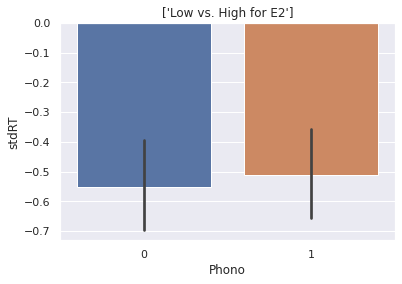

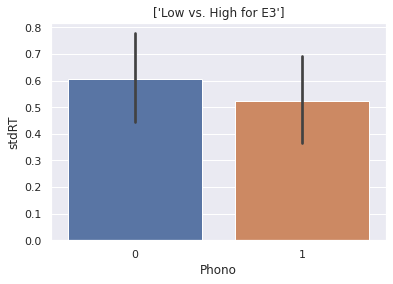

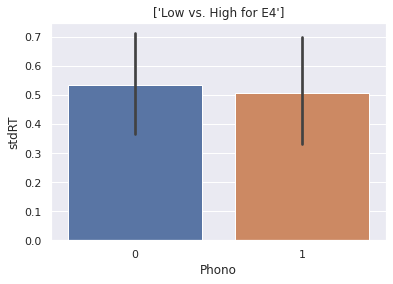

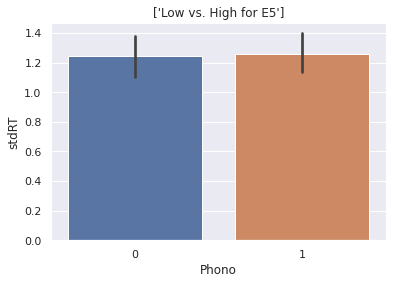

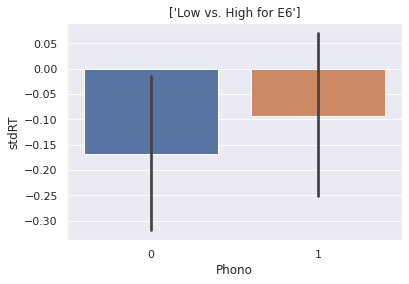

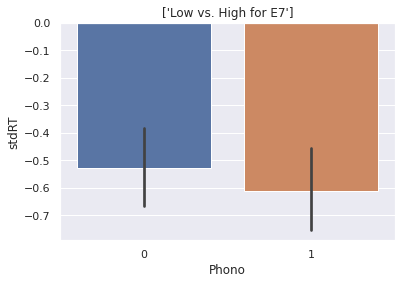

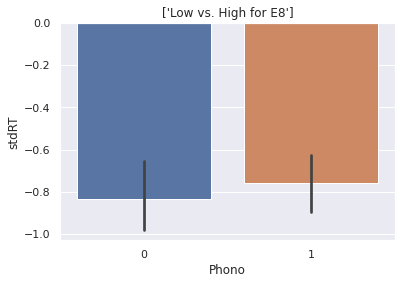

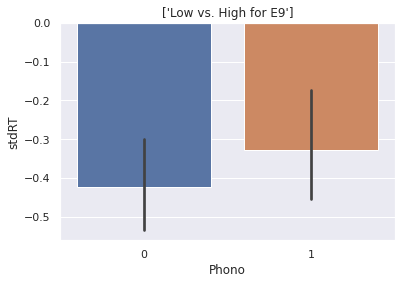

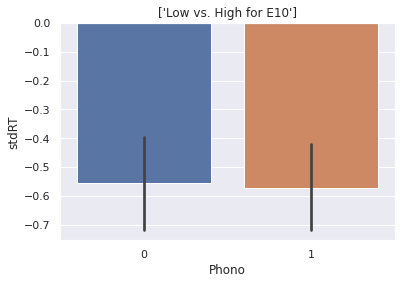

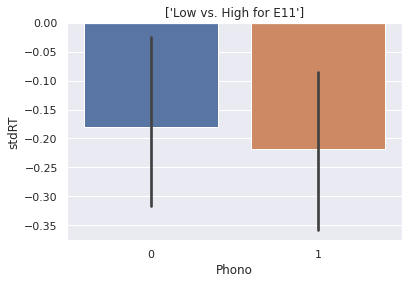

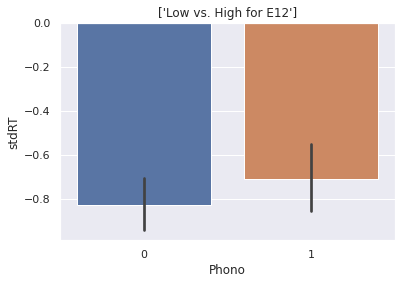

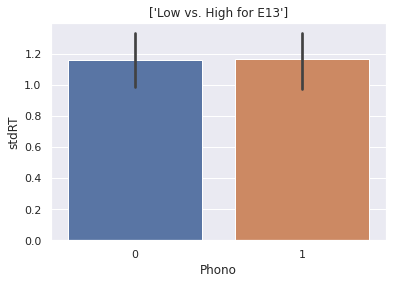

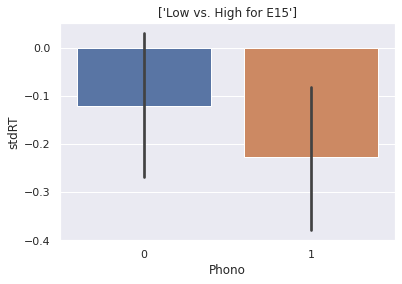

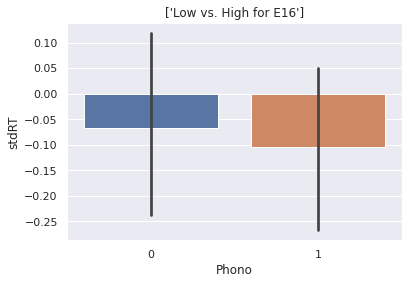

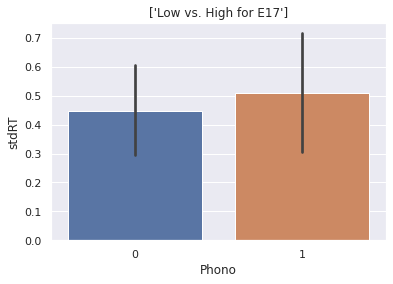

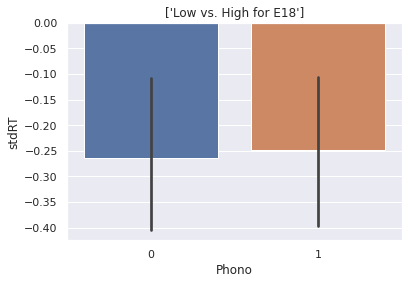

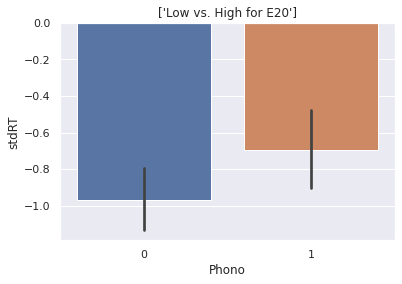

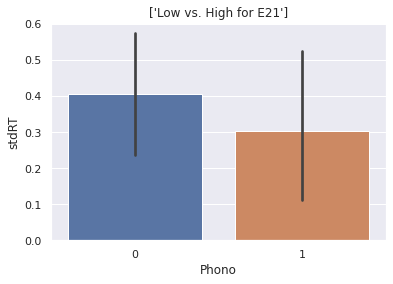

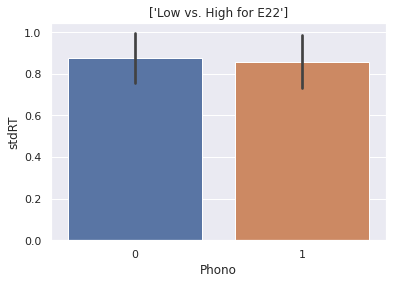

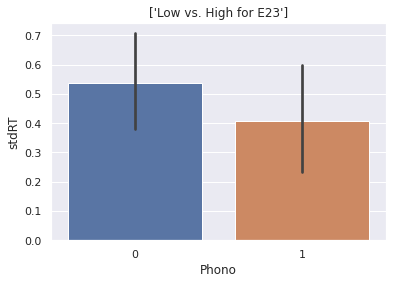

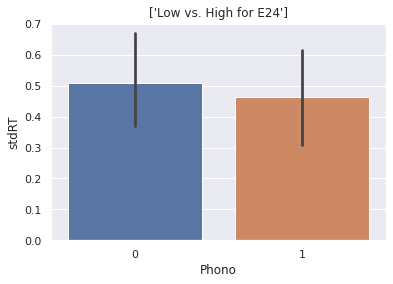

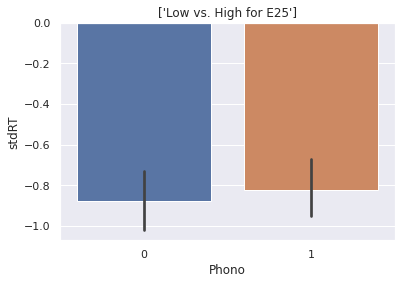

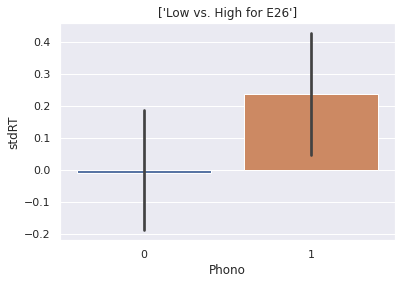

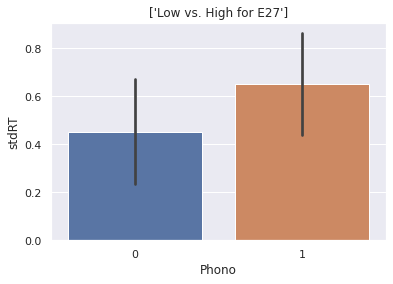

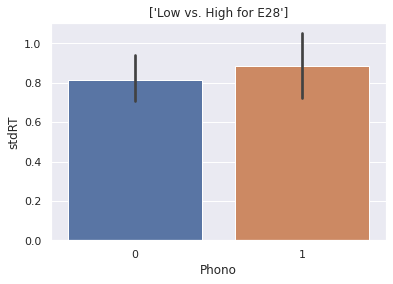

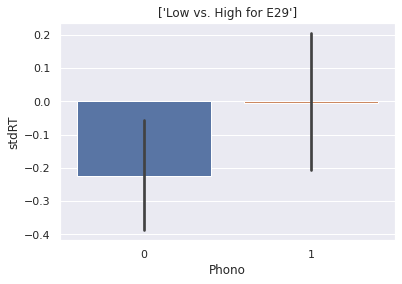

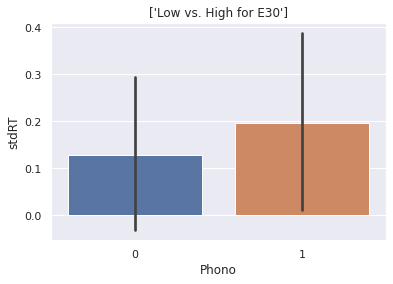

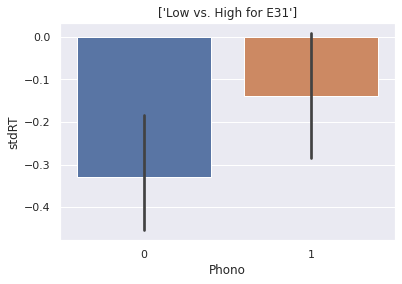

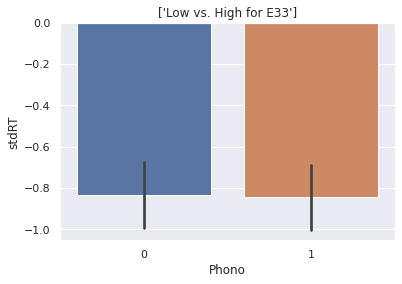

In [333]:
for i in eeg_no_outliers.Subject.unique():
  subset = eeg_no_outliers[eeg_no_outliers['Subject'] == i]
  pl.figure();
  sns.barplot(x = 'Phono', y = 'stdRT', data = subset, estimator = lambda x: sum(x)/len(x));
  pl.title('Low vs. High for ' + subset.Subject.unique());

## Only for correct responses 

In [383]:
correct = eeg_no_outliers[eeg_no_outliers['ResponseCorrect'] == 1]
incorrect = eeg_no_outliers[eeg_no_outliers['ResponseCorrect'] == 0]

In [216]:
correct.head()

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,...,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx,CorrPercentage,Position,Length,stdRT,Lex,Phono
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,...,low non-words,"[array(['yuf.wav'], dtype='<U7'), array(['JcG....",ycG.wav,"[39, 32, 35, 37, 38]",0.875,3,5,0.535034,0,0
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,...,low words,"[[array(['tub.wav'], dtype='<U7')]\n [array(['...",yuT.wav,"[27, 23, 22, 24, 25, 29, 26, 28, 30]",0.875,3,9,-0.366749,1,0
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,...,high words,"[array(['fEl.wav'], dtype='<U7'), array(['lEr....",lEr.wav,"[2, 5, 8, 4, 6]",0.875,1,5,1.474424,1,1
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,...,high non-words,"[[array(['gWT.wav'], dtype='<U7')]\n [array(['...",g@n.wav,"[34, 35, 36, 40, 39, 33, 37]",0.875,0,7,0.234390,0,1
5,5,E2,1,2,16,in_sequence,High Non-Words,1.566338,2.Left,Yes,...,high non-words,"[[array(['g@n.wav'], dtype='<U7')]\n [array(['...",kYl.wav,"[13, 15, 16, 20, 11, 18, 12, 19, 17]",0.875,1,9,1.405773,0,1


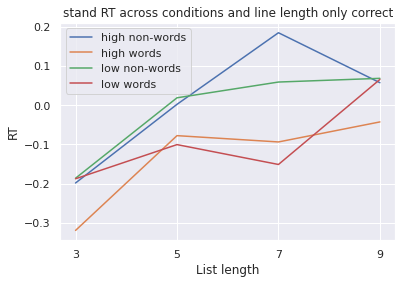

In [384]:
subset = correct.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('stand RT across conditions and line length only correct');  

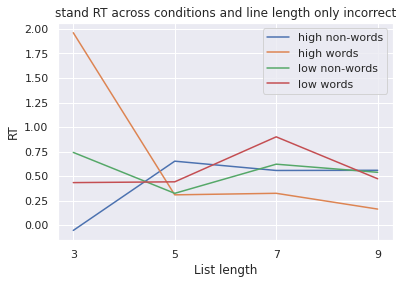

In [385]:
subset = incorrect.groupby(['ProbeCategory', 'Length'])[['stdRT']].mean().reset_index()
pl.figure()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('stand RT across conditions and line length only incorrect');  

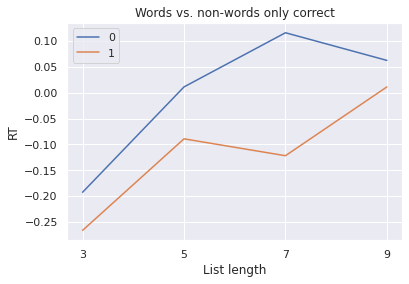

In [387]:
pl.figure()
words_nonwords = correct.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words vs. non-words only correct');  

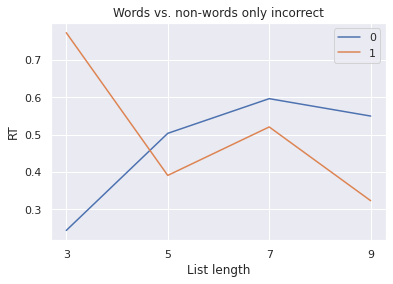

In [225]:
pl.figure()
words_nonwords = incorrect.groupby(['Lex', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Lex.unique():
  x = words_nonwords[words_nonwords['Lex'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Lex.unique())
pl.title('Words vs. non-words only incorrect'); 

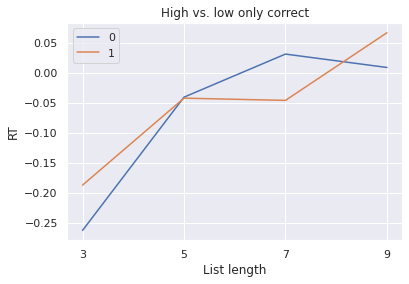

In [388]:
pl.figure()
words_nonwords = correct.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Phono.unique():
  x = words_nonwords[words_nonwords['Phono'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Phono.unique())
pl.title('High vs. low only correct'); 

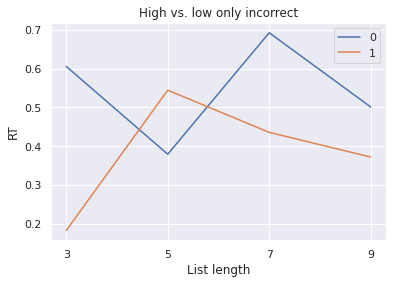

In [226]:
pl.figure()
words_nonwords = incorrect.groupby(['Phono', 'Length'])[['stdRT']].mean().reset_index()
for i in words_nonwords.Phono.unique():
  x = words_nonwords[words_nonwords['Phono'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(words_nonwords.Phono.unique())
pl.title('High vs. low only incorrect'); 